In [1]:
# pip install cvxpy


Phase Shifts (radians):
Element 1: 2.4374 radians
Element 2: 2.4374 radians
Element 3: -0.2160 radians
Element 4: -0.2160 radians
Element 5: -2.8693 radians
Element 6: -2.8693 radians
Element 7: 0.7606 radians
Element 8: 0.7606 radians
Element 9: -1.9531 radians
Element 10: -1.9531 radians
Element 11: 1.6768 radians
Element 12: 1.6768 radians
Element 13: -0.9765 radians
Element 14: -0.9765 radians
Element 15: 2.6533 radians
Element 16: 2.6533 radians
Element 17: -2.6533 radians
Element 18: -2.6533 radians
Element 19: 0.9765 radians
Element 20: 0.9765 radians
Element 21: -1.6768 radians
Element 22: -1.6768 radians
Element 23: 1.9531 radians
Element 24: 1.9531 radians
Element 25: -0.7606 radians
Element 26: -0.7606 radians
Element 27: 2.8693 radians
Element 28: 2.8693 radians
Element 29: 0.2160 radians
Element 30: 0.2160 radians
Element 31: -2.4374 radians
Element 32: -2.4374 radians


<ipython-input-26-91fabb7ace2b>:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0, 1] = plt.subplot(2, 2, 2, polar=True)
<ipython-input-26-91fabb7ace2b>:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[1, 1] = plt.subplot(2, 2, 4, polar=True)


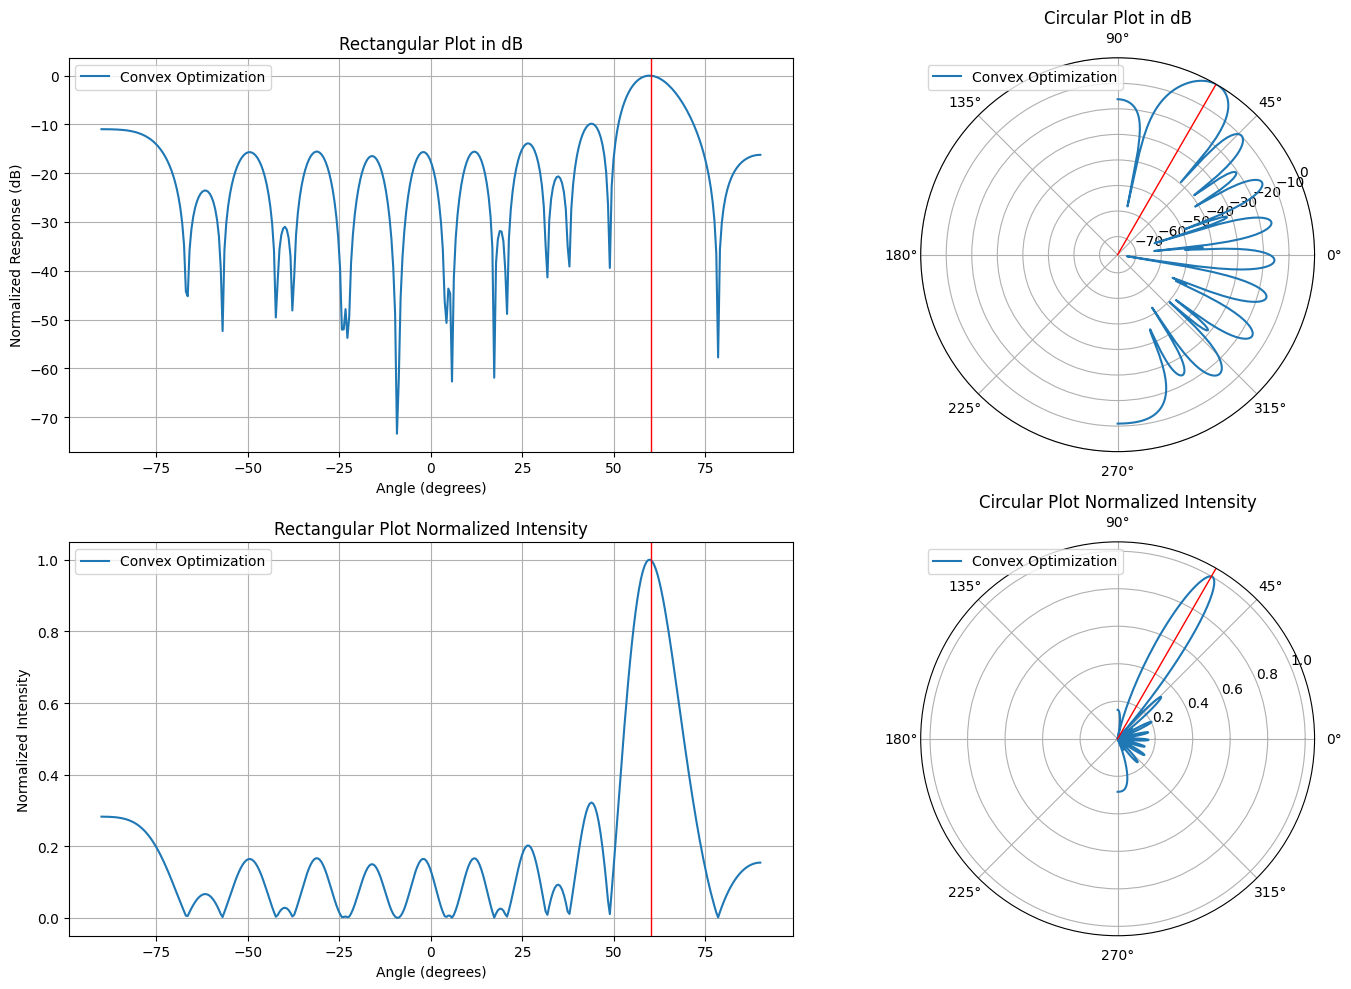

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constants
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = speed_of_sound_in_water(temperature)  # Speed of sound in water at the given temperature
wavelength = speed_of_sound / frequency  # Wavelength in meters

# Antenna array setup
element_positions = [-0.00182, -0.00171, -0.0016, -0.00149, -0.00138, -0.00127, -0.00116, -0.00105,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165,  0.000275,  0.000385,  0.000495,  0.000605,  0.000715,  0.000825,  0.000935,
                     0.00105,  0.00116,  0.00127,  0.00138,  0.00149,  0.0016,  0.00171,  0.00182]

# Desired signal direction in degrees
theta_s = 60  # Desired signal direction
theta_i = []  # No interference directions in this example
interference_power = [1] * len(theta_i)  # Interference power for each direction

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    array_positions = np.array(array_positions)  # Convert to numpy array
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convex Optimization-based Beamforming function with paired phase constraints
def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
    num_pairs = len(element_positions) // 2  # Number of pairs
    v_s = steering_vector(theta_s, element_positions, wavelength)
    v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

    # Define the optimization variables and constraints
    w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
    w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

    constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
    interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

    # Define the problem
    objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
    prob = cp.Problem(objective, constraints + interference_constraints)

    # Solve the problem
    prob.solve()
    w_opt = w.value
    return w_opt

# Beamforming weights
w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i, interference_power=interference_power)

# Function to print phase shifts
def print_phase_shifts(weights):
    phases = np.angle(weights)
    print("\nPhase Shifts (radians):")
    for i, phase in enumerate(phases):
        print(f"Element {i + 1}: {phase:.4f} radians")

# Function to plot beam pattern with the desired layout
def plot_beam_patterns(weights, label, element_positions, wavelength, theta_s, theta_i):
    angles = np.linspace(-90, 90, 360)
    beam_pattern = np.abs([np.conj(steering_vector(deg, element_positions, wavelength).T) @ weights for deg in angles])
    beam_pattern_db = 20 * np.log10(beam_pattern / np.max(beam_pattern))
    beam_pattern_normalized = beam_pattern / np.max(beam_pattern)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Rectangular plot in dB
    axs[0, 0].plot(angles, beam_pattern_db, label=label)
    axs[0, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    for theta in theta_i:
        axs[0, 0].axvline(theta, color='red', linestyle='--', linewidth=1, label='_nolegend_')
    axs[0, 0].set_title('Rectangular Plot in dB')
    axs[0, 0].set_xlabel('Angle (degrees)')
    axs[0, 0].set_ylabel('Normalized Response (dB)')
    axs[0, 0].grid(True)

    # Circular plot in dB
    axs[0, 1] = plt.subplot(2, 2, 2, polar=True)
    axs[0, 1].plot(np.deg2rad(angles), beam_pattern_db, label=label)
    axs[0, 1].axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    for theta in theta_i:
        axs[0, 1].axvline(np.deg2rad(theta), color='red', linestyle='--', linewidth=1, label='_nolegend_')
    axs[0, 1].set_title('Circular Plot in dB')

    # Rectangular plot normalized intensity
    axs[1, 0].plot(angles, beam_pattern_normalized, label=label)
    axs[1, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    for theta in theta_i:
        axs[1, 0].axvline(theta, color='red', linestyle='--', linewidth=1, label='_nolegend_')
    axs[1, 0].set_title('Rectangular Plot Normalized Intensity')
    axs[1, 0].set_xlabel('Angle (degrees)')
    axs[1, 0].set_ylabel('Normalized Intensity')
    axs[1, 0].grid(True)

    # Circular plot normalized intensity
    axs[1, 1] = plt.subplot(2, 2, 4, polar=True)
    axs[1, 1].plot(np.deg2rad(angles), beam_pattern_normalized, label=label)
    axs[1, 1].axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    for theta in theta_i:
        axs[1, 1].axvline(np.deg2rad(theta), color='red', linestyle='--', linewidth=1, label='_nolegend_')
    axs[1, 1].set_title('Circular Plot Normalized Intensity')

    for ax in axs.flat:
        if hasattr(ax, 'legend'):
            ax.legend()

    plt.tight_layout()
    plt.show()

# Print the phase shifts for each element
print_phase_shifts(w_opt)

# Plot beam pattern for convex optimization
plot_beam_patterns(w_opt, "Convex Optimization", element_positions, wavelength, theta_s, theta_i)


Magnitudes before quantization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Phases before quantization: [ 2.43736256  2.43736256 -0.21596439 -0.21596439 -2.86929134 -2.86929134
  0.76056702  0.76056702 -1.95306282 -1.95306282  1.67679554  1.67679554
 -0.97653141 -0.97653141  2.65332695  2.65332695 -2.65332695 -2.65332695
  0.97653141  0.97653141 -1.67679554 -1.67679554  1.95306282  1.95306282
 -0.76056702 -0.76056702  2.86929134  2.86929134  0.21596439  0.21596439
 -2.43736256 -2.43736256]
Magnitudes after quantization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]

Phase Shifts After Quantization:
phase_delays = [ 2.4276, 2.4276, -0.2142, -0.2142, -2.8560, -2.8560, 0.7854, 0.7854, -1.9278, -1.9278, 1.6422, 1.6422, -0.9996, -0.9996, 2.6418, 2.6418, -2.6418, -2.6418, 0.9996, 0.9996, -1.6422, -1.6422, 1.9278, 1.9278, -0.7854, -0.7854, 2.8560, 2.8560, 0.2142, 0.2142, -2.4276, -2.427

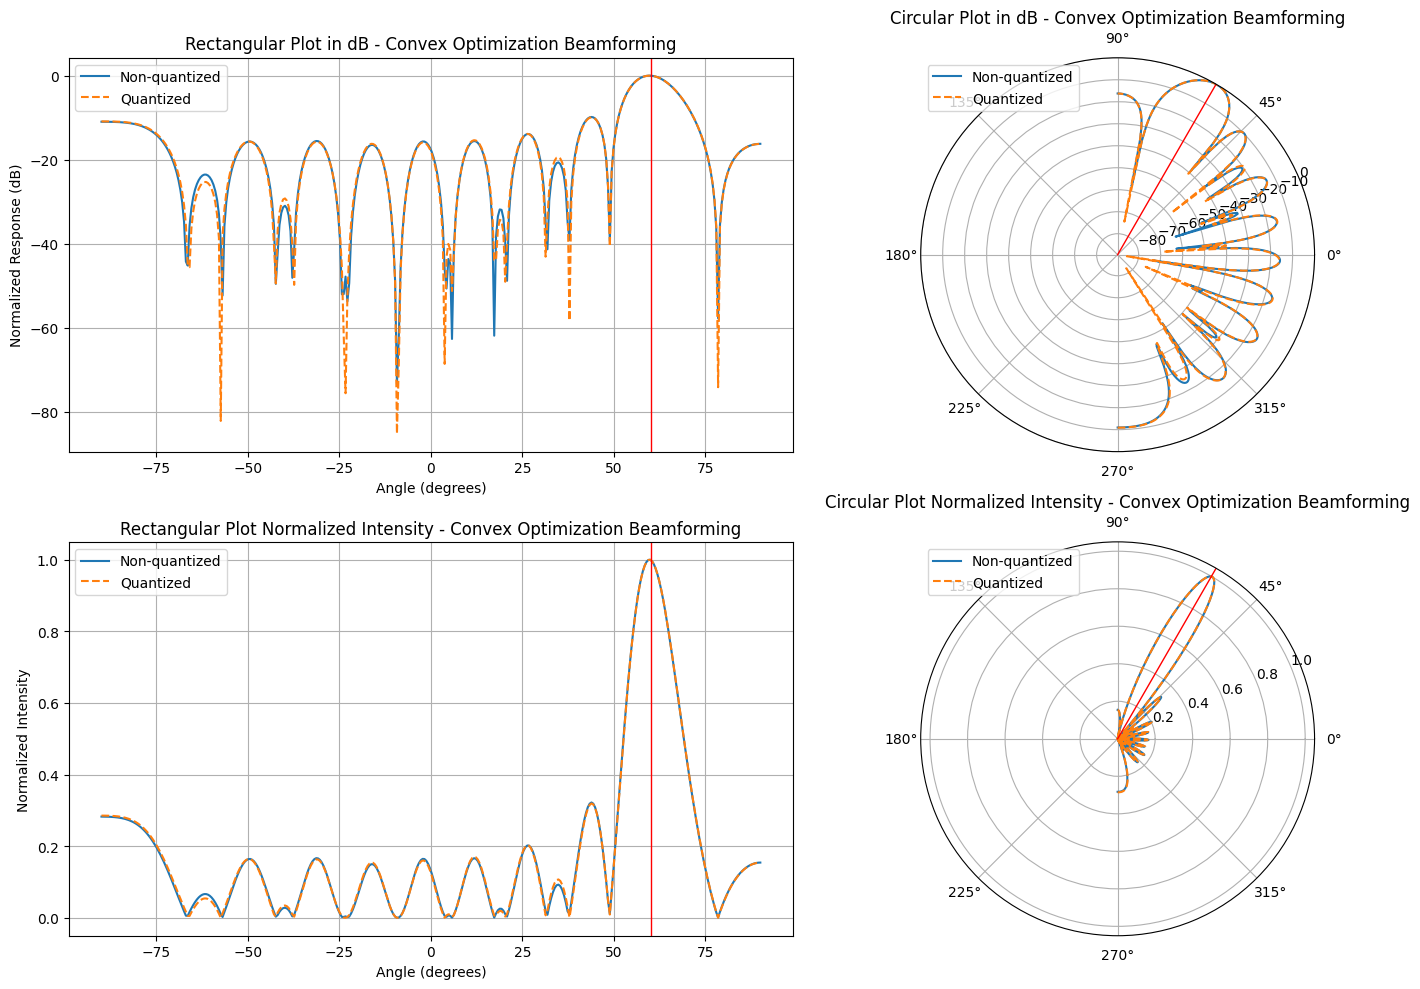

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constants
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = speed_of_sound_in_water(temperature)  # Speed of sound in water at the given temperature
wavelength = speed_of_sound / frequency  # Wavelength in meters

# Antenna array setup
element_positions = [-0.00182, -0.00171, -0.0016, -0.00149, -0.00138, -0.00127, -0.00116, -0.00105,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165,  0.000275,  0.000385,  0.000495,  0.000605,  0.000715,  0.000825,  0.000935,
                     0.00105,  0.00116,  0.00127,  0.00138,  0.00149,  0.0016,  0.00171,  0.00182]

# Desired signal direction in degrees
theta_s = 60  # Desired signal direction
theta_i = []  # No interference directions in this example
interference_power = [1] * len(theta_i)  # Interference power for each direction

# Define discretized phase shift and discrete amplitudes
discretized_phase_shift = 2 * np.pi / 44  # Example discretization value
discrete_amplitudes = [0, 0.5, 1]  # Example amplitude values

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    array_positions = np.array(array_positions)  # Convert to numpy array
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convex Optimization-based Beamforming function with paired phase constraints
def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
    num_pairs = len(element_positions) // 2  # Number of pairs
    v_s = steering_vector(theta_s, element_positions, wavelength)
    v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

    # Define the optimization variables and constraints
    w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
    w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

    constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
    interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

    # Define the problem
    objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
    prob = cp.Problem(objective, constraints + interference_constraints)

    # Solve the problem
    prob.solve()
    w_opt = w.value
    return w_opt

# Beamforming weights
w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i, interference_power=interference_power)

# Post-process the weights to match the chip's specifications
def post_process_weights(weights, discretized_phase_shift, discrete_amplitudes):
    # Normalize weights
    max_magnitude = np.max(np.abs(weights))
    normalized_weights = weights / max_magnitude

    phases = np.angle(normalized_weights)
    magnitudes = np.abs(normalized_weights)

    print("Magnitudes before quantization:", magnitudes)
    print("Phases before quantization:", phases)

    # Quantize phases
    quantized_phases = np.round(phases / (discretized_phase_shift / 2)) * (discretized_phase_shift / 2)

    # Discretize amplitudes
    quantized_magnitudes = np.zeros_like(magnitudes)
    for i in range(len(magnitudes)):
        quantized_magnitudes[i] = min(discrete_amplitudes, key=lambda x: abs(x - magnitudes[i]))

    print("Magnitudes after quantization:", quantized_magnitudes)
    # Print the phase shifts after quantization with commas
    print("\nPhase Shifts After Quantization:")
    print("phase_delays = [", ", ".join(f"{phase:.4f}" for phase in quantized_phases), "];")


    quantized_weights = quantized_magnitudes * np.exp(1j * quantized_phases)
    return quantized_weights, quantized_magnitudes, quantized_phases

# Function to print power, phase shift, amplitude, clock cycles, encoded delay, hex value, and clock cycles in seconds
def print_weights_info(weights, magnitudes, phases, label, discretized_phase_shift):
    powers = np.abs(weights)**2
    clock_cycles = np.round(phases / (discretized_phase_shift / 2)).astype(int)
    min_clock_cycle = np.min(clock_cycles)
    adjusted_clock_cycles = (clock_cycles - min_clock_cycle) / 2  # Adjust clock cycles and divide by 2

    # Convert clock cycles to time in seconds
    clock_frequency = 250e6  # 250 MHz
    time_in_seconds = adjusted_clock_cycles / clock_frequency

    def encode_clock_cycles(clock_cycle):
        # Convert to integer and separate integer and fractional parts
        integer_part = int(np.floor(clock_cycle))
        fractional_part = int((clock_cycle - integer_part) * 2)

        # Encode the value
        encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
        return f"{encoded_value:016b}"

    def encode_clock_cycles_to_hex(clock_cycle):
        # Convert to integer and separate integer and fractional parts
        integer_part = int(np.floor(clock_cycle))
        fractional_part = int((clock_cycle - integer_part) * 2)

        # Encode the value
        encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
        return f"{encoded_value:04X}"

    def amplitude_to_hex(magnitude):
        if magnitude == 1:
            return "001E"
        elif magnitude == 0.5:
            return "0020"
        elif magnitude == 0:
            return "1111"
        else:
            return "0000"  # Default for any unexpected magnitude value

    hex_values = []
    amplitude_hex_values = []
    time_in_seconds_array = []

    print(f"\n{label} Beamforming Weights:")
    print("Node\tPower\t\tPhase Shift (radians)\tAmplitude\tClock Cycles\tEncoded Delay\tDelay Hex\tAmplitude Hex\tTime (s)")
    for i, (power, phase, magnitude, clock_cycle, time_sec) in enumerate(zip(powers, phases, magnitudes, adjusted_clock_cycles, time_in_seconds)):
        encoded_delay = encode_clock_cycles(clock_cycle)
        hex_value = encode_clock_cycles_to_hex(clock_cycle)
        amp_hex = amplitude_to_hex(magnitude)
        hex_values.append(hex_value)
        amplitude_hex_values.append(amp_hex)
        time_in_seconds_array.append(time_sec)
        print(f"{i}\t{power:.4f}\t{phase:.4f}\t\t{magnitude:.1f}\t\t{clock_cycle:.1f}\t\t{encoded_delay}\t{hex_value}\t{amp_hex}\t{time_sec:.8f}")

    return hex_values, amplitude_hex_values, np.array(time_in_seconds_array)

# Combine hex values into 8-digit hex numbers
def combine_hex_values(hex_values):
    combined_hex_values = []
    for i in range(0, len(hex_values), 2):
        combined_hex = hex_values[i + 1] + hex_values[i]
        combined_hex_values.append("0x" + combined_hex)
    return combined_hex_values
'''
# Post-process the weights
w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)
hex_values_quantized, amplitude_hex_values_quantized, time_in_seconds_array = print_weights_info(w_quantized, quantized_magnitudes, quantized_phases, "Quantized", discretized_phase_shift)

# Combine hex values into 8-digit hex numbers
combined_hex_values = combine_hex_values(hex_values_quantized)
combined_amplitude_hex_values = combine_hex_values(amplitude_hex_values_quantized)
print("\nCombined Delay Hex Values:")
print(combined_hex_values)
print("\nCombined Amplitude Hex Values:")
print(combined_amplitude_hex_values)
'''
# Post-process the weights
w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)

# Remove odd nodes from the list
odd_indices = [i for i in range(len(w_quantized)) if i % 2 != 0]
even_w_quantized = np.delete(w_quantized, odd_indices)
even_quantized_magnitudes = np.delete(quantized_magnitudes, odd_indices)
even_quantized_phases = np.delete(quantized_phases, odd_indices)

# Print weights info for even nodes only
hex_values_quantized, amplitude_hex_values_quantized, time_in_seconds_array = print_weights_info(even_w_quantized, even_quantized_magnitudes, even_quantized_phases, "Quantized (Even Nodes)", discretized_phase_shift)

# Combine hex values into 8-digit hex numbers
combined_hex_values = combine_hex_values(hex_values_quantized)
combined_amplitude_hex_values = combine_hex_values(amplitude_hex_values_quantized)
print("\nCombined Delay Hex Values:")
print(combined_hex_values)
print("\nCombined Amplitude Hex Values:")
print(combined_amplitude_hex_values)


# Plot the beam pattern
def plot_beam_pattern(weights1, weights2, element_positions, wavelength, title, theta_s):
    angles = np.linspace(-90, 90, 360)
    beam_pattern1 = np.abs([np.conj(steering_vector(deg, element_positions, wavelength).T) @ weights1 for deg in angles])
    beam_pattern2 = np.abs([np.conj(steering_vector(deg, element_positions, wavelength).T) @ weights2 for deg in angles])

    beam_pattern_db1 = 20 * np.log10(beam_pattern1 / np.max(beam_pattern1))
    beam_pattern_db2 = 20 * np.log10(beam_pattern2 / np.max(beam_pattern2))

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Rectangular plot in dB
    axs[0, 0].plot(angles, beam_pattern_db1, label='Non-quantized')
    axs[0, 0].plot(angles, beam_pattern_db2, label='Quantized', linestyle='dashed')
    axs[0, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    axs[0, 0].set_title(f'Rectangular Plot in dB - {title}')
    axs[0, 0].set_xlabel('Angle (degrees)')
    axs[0, 0].set_ylabel('Normalized Response (dB)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Circular plot in dB
    axs[0, 1].remove()  # Remove the overlapping axis first
    ax_polar_db = plt.subplot(2, 2, 2, polar=True)
    ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db1, label='Non-quantized')
    ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db2, label='Quantized', linestyle='dashed')
    ax_polar_db.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_db.set_title(f'Circular Plot in dB - {title}')
    ax_polar_db.legend()

    # Rectangular plot normalized intensity
    axs[1, 0].plot(angles, beam_pattern1 / np.max(beam_pattern1), label='Non-quantized')
    axs[1, 0].plot(angles, beam_pattern2 / np.max(beam_pattern2), label='Quantized', linestyle='dashed')
    axs[1, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    axs[1, 0].set_title(f'Rectangular Plot Normalized Intensity - {title}')
    axs[1, 0].set_xlabel('Angle (degrees)')
    axs[1, 0].set_ylabel('Normalized Intensity')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Circular plot normalized intensity
    axs[1, 1].remove()  # Remove the overlapping axis first
    ax_polar_intensity = plt.subplot(2, 2, 4, polar=True)
    ax_polar_intensity.plot(np.deg2rad(angles), beam_pattern1 / np.max(beam_pattern1), label='Non-quantized')
    ax_polar_intensity.plot(np.deg2rad(angles), beam_pattern2 / np.max(beam_pattern2), label='Quantized', linestyle='dashed')
    ax_polar_intensity.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_intensity.set_title(f'Circular Plot Normalized Intensity - {title}')
    ax_polar_intensity.legend()

    plt.tight_layout()
    plt.show()

# Plot beam pattern
plot_beam_pattern(w_opt, w_quantized, element_positions, wavelength, "Convex Optimization Beamforming", theta_s)

Magnitudes before quantization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Phases before quantization: [ 2.78122704  2.78122704  0.08503879  0.08503879 -2.61114945 -2.61114945
  0.97584761  0.97584761 -1.78161764 -1.78161764  1.80537943  1.80537943
 -0.89080882 -0.89080882  2.69618824  2.69618824 -2.69618824 -2.69618824
  0.89080882  0.89080882 -1.80537943 -1.80537943  1.78161764  1.78161764
 -0.97584761 -0.97584761  2.61114945  2.61114945 -0.08503879 -0.08503879
 -2.78122704 -2.78122704]
Magnitudes after quantization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]

Phase Shifts After Quantization:
phase_delays = [ 2.7846, 2.7846, 0.0714, 0.0714, -2.6418, -2.6418, 0.9996, 0.9996, -1.7850, -1.7850, 1.7850, 1.7850, -0.8568, -0.8568, 2.7132, 2.7132, -2.7132, -2.7132, 0.8568, 0.8568, -1.7850, -1.7850, 1.7850, 1.7850, -0.9996, -0.9996, 2.6418, 2.6418, -0.0714, -0.0714, -2.7846, -2.784

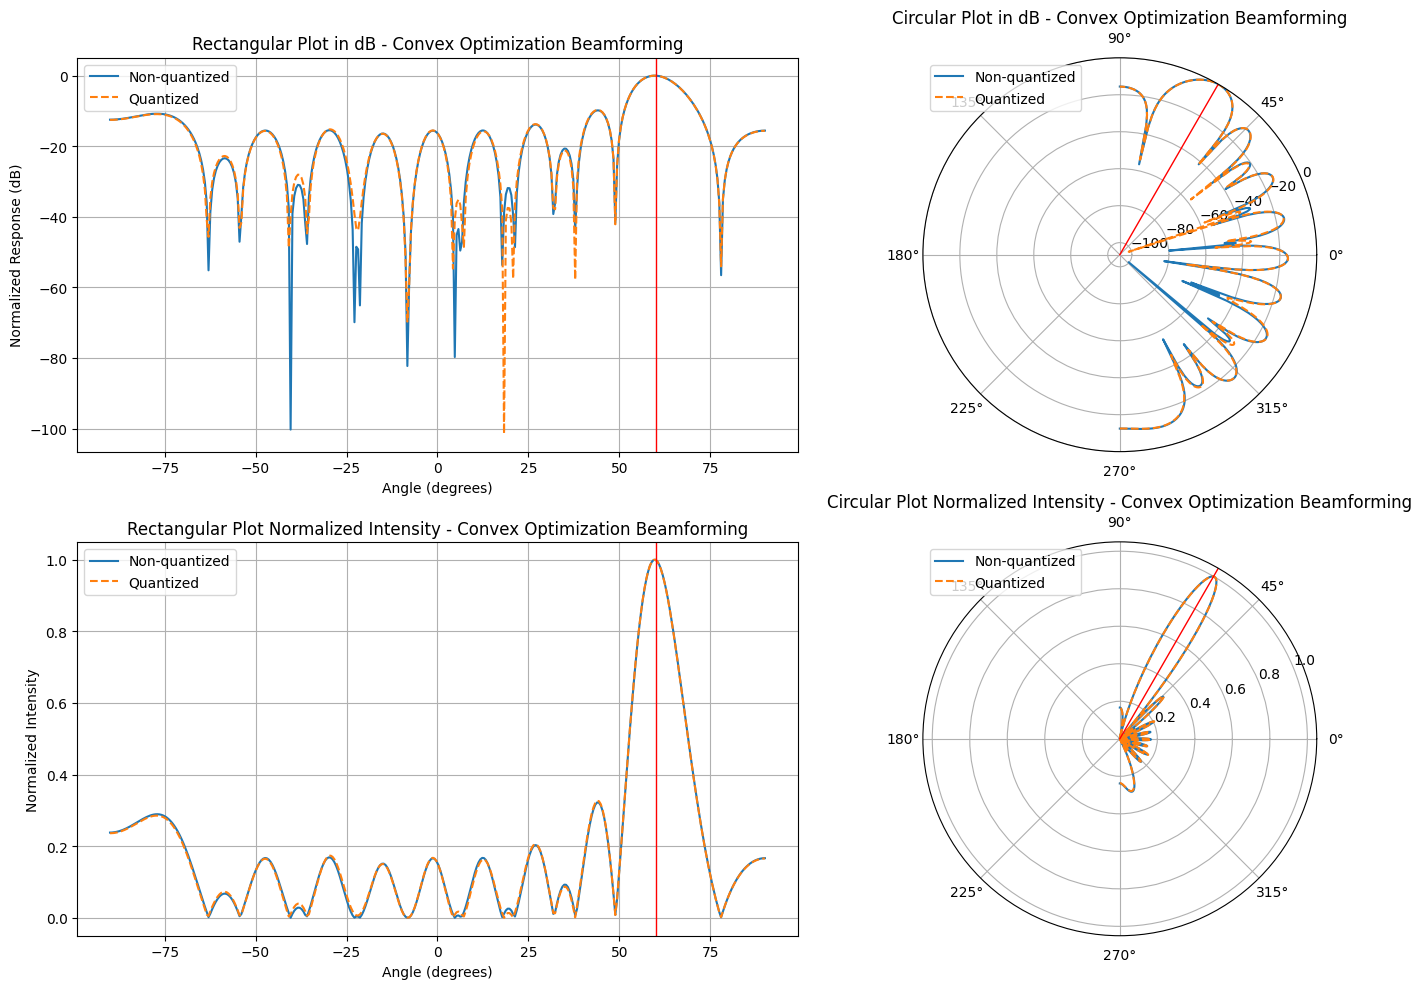

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constants
num_elements = 32  # Number of elements producing sound
total_positions = 34  # Total positions in the array, including empty ones
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Chip specific constants
beamformer_frequency = 250e6  # Beamformer frequency in Hz
discretized_phase_shift = 2 * np.pi / 44  # Discretized phase shift increment
discrete_amplitudes = [0, 0.5, 1]  # Discrete amplitude control

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = 1500 #speed_of_sound_in_water(temperature)  # Speed of sound in water at the given temperature
wavelength = speed_of_sound / frequency  # Wavelength in meters
d = 110e-6  # Element spacing in meters (110 µm)

# Antenna array setup
element_positions = [-0.00182, -0.00171, -0.0016, -0.00149, -0.00138, -0.00127, -0.00116, -0.00105,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165,  0.000275,  0.000385,  0.000495,  0.000605,  0.000715,  0.000825,  0.000935,
                     0.00105,  0.00116,  0.00127,  0.00138,  0.00149,  0.0016,  0.00171,  0.00182]

#----------------------------------------------------------------------
# Desired signal direction in degrees
theta_s = 60  # Desired signal direction
theta_i = []  # No interference directions in this example
interference_power = [1] * len(theta_i)  # Interference power for each direction
#----------------------------------------------------------------------

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    array_positions = np.array(array_positions)  # Convert to numpy array
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convex Optimization-based Beamforming function with paired phase constraints
def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
    num_pairs = len(element_positions) // 2  # Number of pairs
    v_s = steering_vector(theta_s, element_positions, wavelength)
    v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

    # Define the optimization variables and constraints
    w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
    w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

    constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
    interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

    # Define the problem
    objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
    prob = cp.Problem(objective, constraints + interference_constraints)

    # Solve the problem
    prob.solve()
    w_opt = w.value
    return w_opt

# Beamforming weights
w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i, interference_power=interference_power)

# Post-process the weights to match the chip's specifications
def post_process_weights(weights, discretized_phase_shift, discrete_amplitudes):
    # Normalize weights
    max_magnitude = np.max(np.abs(weights))
    normalized_weights = weights / max_magnitude

    phases = np.angle(normalized_weights)
    magnitudes = np.abs(normalized_weights)

    print("Magnitudes before quantization:", magnitudes)
    print("Phases before quantization:", phases)

    # Quantize phases
    quantized_phases = np.round(phases / (discretized_phase_shift / 2)) * (discretized_phase_shift / 2)

    # Discretize amplitudes
    quantized_magnitudes = np.zeros_like(magnitudes)
    for i in range(len(magnitudes)):
        quantized_magnitudes[i] = min(discrete_amplitudes, key=lambda x: abs(x - magnitudes[i]))

    print("Magnitudes after quantization:", quantized_magnitudes)
    # Print the phase shifts after quantization with commas
    print("\nPhase Shifts After Quantization:")
    print("phase_delays = [", ", ".join(f"{phase:.4f}" for phase in quantized_phases), "];")


    quantized_weights = quantized_magnitudes * np.exp(1j * quantized_phases)
    return quantized_weights, quantized_magnitudes, quantized_phases

# Function to print power, phase shift, amplitude, clock cycles, encoded delay, hex value, and clock cycles in seconds
def print_weights_info(weights, magnitudes, phases, label, discretized_phase_shift):
    powers = np.abs(weights)**2
    clock_cycles = np.round(phases / (discretized_phase_shift / 2)).astype(int)
    min_clock_cycle = np.min(clock_cycles)
    adjusted_clock_cycles = (clock_cycles - min_clock_cycle) / 2  # Adjust clock cycles and divide by 2

    # Convert clock cycles to time in seconds
    clock_frequency = 250e6  # 250 MHz
    time_in_seconds = adjusted_clock_cycles / clock_frequency

    def encode_clock_cycles(clock_cycle):
        # Convert to integer and separate integer and fractional parts
        integer_part = int(np.floor(clock_cycle))
        fractional_part = int((clock_cycle - integer_part) * 2)

        # Encode the value
        encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
        return f"{encoded_value:016b}"

    def encode_clock_cycles_to_hex(clock_cycle):
        # Convert to integer and separate integer and fractional parts
        integer_part = int(np.floor(clock_cycle))
        fractional_part = int((clock_cycle - integer_part) * 2)

        # Encode the value
        encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
        return f"{encoded_value:04X}"

    def amplitude_to_hex(magnitude):
        if magnitude == 1:
            return "001E"
        elif magnitude == 0.5:
            return "0020"
        elif magnitude == 0:
            return "1111"
        else:
            return "0000"  # Default for any unexpected magnitude value

    hex_values = []
    amplitude_hex_values = []
    time_in_seconds_array = []

    print(f"\n{label} Beamforming Weights:")
    print("Node\tPower\t\tPhase Shift (radians)\tAmplitude\tClock Cycles\tEncoded Delay\tDelay Hex\tAmplitude Hex\tTime (s)")
    for i, (power, phase, magnitude, clock_cycle, time_sec) in enumerate(zip(powers, phases, magnitudes, adjusted_clock_cycles, time_in_seconds)):
        encoded_delay = encode_clock_cycles(clock_cycle)
        hex_value = encode_clock_cycles_to_hex(clock_cycle)
        amp_hex = amplitude_to_hex(magnitude)
        hex_values.append(hex_value)
        amplitude_hex_values.append(amp_hex)
        time_in_seconds_array.append(time_sec)
        print(f"{i}\t{power:.4f}\t{phase:.4f}\t\t{magnitude:.1f}\t\t{clock_cycle:.1f}\t\t{encoded_delay}\t{hex_value}\t{amp_hex}\t{time_sec:.8f}")

    return hex_values, amplitude_hex_values, np.array(time_in_seconds_array)

# Combine hex values into 8-digit hex numbers
def combine_hex_values(hex_values):
    combined_hex_values = []
    for i in range(0, len(hex_values), 2):
        combined_hex = hex_values[i + 1] + hex_values[i]
        combined_hex_values.append("0x" + combined_hex)
    return combined_hex_values
'''
# Post-process the weights
w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)
hex_values_quantized, amplitude_hex_values_quantized, time_in_seconds_array = print_weights_info(w_quantized, quantized_magnitudes, quantized_phases, "Quantized", discretized_phase_shift)

# Combine hex values into 8-digit hex numbers
combined_hex_values = combine_hex_values(hex_values_quantized)
combined_amplitude_hex_values = combine_hex_values(amplitude_hex_values_quantized)
print("\nCombined Delay Hex Values:")
print(combined_hex_values)
print("\nCombined Amplitude Hex Values:")
print(combined_amplitude_hex_values)
'''
# Post-process the weights
w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)

# Remove odd nodes from the list
odd_indices = [i for i in range(len(w_quantized)) if i % 2 != 0]
even_w_quantized = np.delete(w_quantized, odd_indices)
even_quantized_magnitudes = np.delete(quantized_magnitudes, odd_indices)
even_quantized_phases = np.delete(quantized_phases, odd_indices)

# Print weights info for even nodes only
hex_values_quantized, amplitude_hex_values_quantized, time_in_seconds_array = print_weights_info(even_w_quantized, even_quantized_magnitudes, even_quantized_phases, "Quantized (Even Nodes)", discretized_phase_shift)

# Combine hex values into 8-digit hex numbers
combined_hex_values = combine_hex_values(hex_values_quantized)
combined_amplitude_hex_values = combine_hex_values(amplitude_hex_values_quantized)
print("\nCombined Delay Hex Values:")
print(combined_hex_values)
print("\nCombined Amplitude Hex Values:")
print(combined_amplitude_hex_values)


# Plot the beam pattern
def plot_beam_pattern(weights1, weights2, element_positions, wavelength, title, theta_s):
    angles = np.linspace(-90, 90, 360)
    beam_pattern1 = np.abs([np.conj(steering_vector(deg, element_positions, wavelength).T) @ weights1 for deg in angles])
    beam_pattern2 = np.abs([np.conj(steering_vector(deg, element_positions, wavelength).T) @ weights2 for deg in angles])

    beam_pattern_db1 = 20 * np.log10(beam_pattern1 / np.max(beam_pattern1))
    beam_pattern_db2 = 20 * np.log10(beam_pattern2 / np.max(beam_pattern2))

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Rectangular plot in dB
    axs[0, 0].plot(angles, beam_pattern_db1, label='Non-quantized')
    axs[0, 0].plot(angles, beam_pattern_db2, label='Quantized', linestyle='dashed')
    axs[0, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    axs[0, 0].set_title(f'Rectangular Plot in dB - {title}')
    axs[0, 0].set_xlabel('Angle (degrees)')
    axs[0, 0].set_ylabel('Normalized Response (dB)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Circular plot in dB
    axs[0, 1].remove()  # Remove the overlapping axis first
    ax_polar_db = plt.subplot(2, 2, 2, polar=True)
    ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db1, label='Non-quantized')
    ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db2, label='Quantized', linestyle='dashed')
    ax_polar_db.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_db.set_title(f'Circular Plot in dB - {title}')
    ax_polar_db.legend()

    # Rectangular plot normalized intensity
    axs[1, 0].plot(angles, beam_pattern1 / np.max(beam_pattern1), label='Non-quantized')
    axs[1, 0].plot(angles, beam_pattern2 / np.max(beam_pattern2), label='Quantized', linestyle='dashed')
    axs[1, 0].axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')
    axs[1, 0].set_title(f'Rectangular Plot Normalized Intensity - {title}')
    axs[1, 0].set_xlabel('Angle (degrees)')
    axs[1, 0].set_ylabel('Normalized Intensity')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Circular plot normalized intensity
    axs[1, 1].remove()  # Remove the overlapping axis first
    ax_polar_intensity = plt.subplot(2, 2, 4, polar=True)
    ax_polar_intensity.plot(np.deg2rad(angles), beam_pattern1 / np.max(beam_pattern1), label='Non-quantized')
    ax_polar_intensity.plot(np.deg2rad(angles), beam_pattern2 / np.max(beam_pattern2), label='Quantized', linestyle='dashed')
    ax_polar_intensity.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_intensity.set_title(f'Circular Plot Normalized Intensity - {title}')
    ax_polar_intensity.legend()

    plt.tight_layout()
    plt.show()

# Plot beam pattern
plot_beam_pattern(w_opt, w_quantized, element_positions, wavelength, "Convex Optimization Beamforming", theta_s)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constants
num_elements = 32  # Number of elements producing sound
total_positions = 34  # Total positions in the array, including empty ones
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Chip specific constants
beamformer_frequency = 250e6  # Beamformer frequency in Hz
discretized_phase_shift = 2 * np.pi / 44  # Discretized phase shift increment
discrete_amplitudes = [0, 0.5, 1]  # Discrete amplitude control

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = 1500  # Speed of sound in water (approximate)
wavelength = speed_of_sound / frequency  # Wavelength in meters
d = 110e-6  # Element spacing in meters (110 µm)

# Antenna array setup
element_positions = [-0.00182, -0.00171, -0.0016, -0.00149, -0.00138, -0.00127, -0.00116, -0.00105,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165,  0.000275,  0.000385,  0.000495,  0.000605,  0.000715,  0.000825,  0.000935,
                     0.00105,  0.00116,  0.00127,  0.00138,  0.00149,  0.0016,  0.00171,  0.00182]

# Desired signal direction in degrees
theta_s = 10  # Desired signal direction
theta_i = []  # No interference directions in this example
interference_power = [1] * len(theta_i)  # Interference power for each direction

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    array_positions = np.array(array_positions)  # Convert to numpy array
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convex Optimization-based Beamforming function with paired phase constraints
def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
    num_pairs = len(element_positions) // 2  # Number of pairs
    v_s = steering_vector(theta_s, element_positions, wavelength)
    v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

    # Define the optimization variables and constraints
    w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
    w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

    constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
    interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

    # Define the problem
    objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
    prob = cp.Problem(objective, constraints + interference_constraints)

    # Solve the problem
    prob.solve()
    w_opt = w.value
    return w_opt

# Beamforming weights
w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i, interference_power=interference_power)

# Post-process the weights to match the chip's specifications
def post_process_weights(weights, discretized_phase_shift, discrete_amplitudes):
    # Normalize weights
    max_magnitude = np.max(np.abs(weights))
    normalized_weights = weights / max_magnitude

    phases = np.angle(normalized_weights)
    magnitudes = np.abs(normalized_weights)

    # Quantize phases
    quantized_phases = np.round(phases / (discretized_phase_shift / 2)) * (discretized_phase_shift / 2)

    # Discretize amplitudes
    quantized_magnitudes = np.zeros_like(magnitudes)
    for i in range(len(magnitudes)):
        quantized_magnitudes[i] = min(discrete_amplitudes, key=lambda x: abs(x - magnitudes[i]))

    quantized_weights = quantized_magnitudes * np.exp(1j * quantized_phases)
    return quantized_weights, quantized_magnitudes, quantized_phases

# Function to print power, phase shift, amplitude, clock cycles, encoded delay, hex value, and clock cycles in seconds
def print_weights_info(weights, magnitudes, phases, discretized_phase_shift):
    clock_cycles = np.round(phases / (discretized_phase_shift / 2)).astype(int)
    min_clock_cycle = np.min(clock_cycles)
    adjusted_clock_cycles = (clock_cycles - min_clock_cycle) / 2  # Adjust clock cycles and divide by 2

    def encode_clock_cycles_to_hex(clock_cycle):
        # Convert to integer and separate integer and fractional parts
        integer_part = int(np.floor(clock_cycle))
        fractional_part = int((clock_cycle - integer_part) * 2)

        # Encode the value
        encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
        return f"{encoded_value:04X}"

    hex_values = []
    for clock_cycle in adjusted_clock_cycles:
        hex_value = encode_clock_cycles_to_hex(clock_cycle)
        hex_values.append(hex_value)

    return hex_values

# Combine hex values into 8-digit hex numbers
def combine_hex_values(hex_values):
    combined_hex_values = []
    for i in range(0, len(hex_values), 2):
        combined_hex = hex_values[i + 1] + hex_values[i]
        combined_hex_values.append("0x" + combined_hex)
    return combined_hex_values

# Post-process the weights
w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)

# Remove odd nodes from the list
odd_indices = [i for i in range(len(w_quantized)) if i % 2 != 0]
even_w_quantized = np.delete(w_quantized, odd_indices)
even_quantized_magnitudes = np.delete(quantized_magnitudes, odd_indices)
even_quantized_phases = np.delete(quantized_phases, odd_indices)

# Generate hex values for even nodes only
hex_values_quantized = print_weights_info(even_w_quantized, even_quantized_magnitudes, even_quantized_phases, discretized_phase_shift)

# Combine hex values into 8-digit hex numbers
combined_hex_values = combine_hex_values(hex_values_quantized)

# Output the array of hex delay values
print("\nCombined Delay Hex Values:")
print(combined_hex_values)



Combined Delay Hex Values:
['0x40034007', '0x00280000', '0x40200024', '0x0019401C', '0x400D0011', '0x00064009', '0x002A0002', '0x40224026']


In [ ]:
import numpy as np
import cvxpy as cp

def beamforming_hex_values(theta_s, theta_i):
    # Constants
    num_elements = 32  # Number of elements producing sound
    total_positions = 34  # Total positions in the array, including empty ones
    temperature = 21  # in Celsius
    frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

    # Chip specific constants
    beamformer_frequency = 250e6  # Beamformer frequency in Hz
    discretized_phase_shift = 2 * np.pi / 44  # Discretized phase shift increment
    discrete_amplitudes = [0, 0.5, 1]  # Discrete amplitude control

    # Function to calculate the speed of sound in water based on temperature
    def speed_of_sound_in_water(T):
        return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

    speed_of_sound = speed_of_sound_in_water(temperature)  # Speed of sound in water at the given temperature
    wavelength = speed_of_sound / frequency  # Wavelength in meters
    d = 110e-6  # Element spacing in meters (110 µm)

    # Antenna array setup
    element_positions = [-0.00182, -0.00171, -0.0016, -0.00149, -0.00138, -0.00127, -0.00116, -0.00105,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165,  0.000275,  0.000385,  0.000495,  0.000605,  0.000715,  0.000825,  0.000935,
                     0.00105,  0.00116,  0.00127,  0.00138,  0.00149,  0.0016,  0.00171,  0.00182]

    # Calculate steering vector
    def steering_vector(theta, array_positions, wavelength):
        k = 2 * np.pi / wavelength
        angles_rad = np.deg2rad(theta)
        array_positions = np.array(array_positions)  # Convert to numpy array
        steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
        return steering

    # Convex Optimization-based Beamforming function with paired phase constraints
    def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
        num_pairs = len(element_positions) // 2  # Number of pairs
        v_s = steering_vector(theta_s, element_positions, wavelength)
        v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

        # Define the optimization variables and constraints
        w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
        w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

        constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
        interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

        # Define the problem
        objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
        prob = cp.Problem(objective, constraints + interference_constraints)

        # Solve the problem
        prob.solve()
        w_opt = w.value
        return w_opt

    # Beamforming weights
    w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i)

    # Post-process the weights to match the chip's specifications
    def post_process_weights(weights, discretized_phase_shift, discrete_amplitudes):
        # Normalize weights
        max_magnitude = np.max(np.abs(weights))
        normalized_weights = weights / max_magnitude

        phases = np.angle(normalized_weights)
        magnitudes = np.abs(normalized_weights)

        # Quantize phases
        quantized_phases = np.round(phases / (discretized_phase_shift / 2)) * (discretized_phase_shift / 2)

        # Discretize amplitudes
        quantized_magnitudes = np.zeros_like(magnitudes)
        for i in range(len(magnitudes)):
            quantized_magnitudes[i] = min(discrete_amplitudes, key=lambda x: abs(x - magnitudes[i]))

        quantized_weights = quantized_magnitudes * np.exp(1j * quantized_phases)
        return quantized_weights, quantized_magnitudes, quantized_phases

    # Function to calculate hex delay values
    def calculate_hex_delays(phases, discretized_phase_shift):
        clock_cycles = np.round(phases / (discretized_phase_shift / 2)).astype(int)
        min_clock_cycle = np.min(clock_cycles)
        adjusted_clock_cycles = (clock_cycles - min_clock_cycle) / 2  # Adjust clock cycles and divide by 2

        def encode_clock_cycles_to_hex(clock_cycle):
            # Convert to integer and separate integer and fractional parts
            integer_part = int(np.floor(clock_cycle))
            fractional_part = int((clock_cycle - integer_part) * 2)

            # Encode the value
            encoded_value = (integer_part & 0x3FFF) | (fractional_part << 14)
            return f"{encoded_value:04X}"

        hex_values = [encode_clock_cycles_to_hex(clock_cycle) for clock_cycle in adjusted_clock_cycles]
        return hex_values

    # Post-process the weights
    w_quantized, quantized_magnitudes, quantized_phases = post_process_weights(w_opt, discretized_phase_shift, discrete_amplitudes)

    # Remove odd nodes from the list
    odd_indices = [i for i in range(len(w_quantized)) if i % 2 != 0]
    even_w_quantized = np.delete(w_quantized, odd_indices)
    even_quantized_phases = np.delete(quantized_phases, odd_indices)

    # Calculate hex delay values for even nodes only
    hex_values_quantized = calculate_hex_delays(even_quantized_phases, discretized_phase_shift)

    # Combine hex values into 8-digit hex numbers
    combined_hex_values = []
    for i in range(0, len(hex_values_quantized), 2):
        combined_hex = hex_values_quantized[i + 1] + hex_values_quantized[i]
        combined_hex_values.append("0x" + combined_hex)

    return combined_hex_values

# Example usage
theta_s = 10  # Signal direction in degrees
theta_i = []  # Interference directions (empty for this example)

combined_delay_hex_values = beamforming_hex_values(theta_s, theta_i)
print("Combined Delay Hex Values:")
print(combined_delay_hex_values)

# Main loop to run beamforming over angles from -40 to 40 degrees
angle_range = range(-40, 40)  # From -40 to 40 degrees inclusive
all_delay_hex_values = []

for theta_s in angle_range:
    combined_delay_hex_values = beamforming_hex_values(theta_s, [])
    all_delay_hex_values.append(combined_delay_hex_values)

# Print the array of delay hex values in Python list format
print("all_delay_hex_values = [")
for hex_values in all_delay_hex_values:
    print("    ", hex_values, ",")
print("]")
all_delay_hex_values = [
    ['0x00160049', '0x4044402D', '0x00294011', '0x400D0040', '0x0009403B', '0x00370020', '0x401B4004', '0x00000033'],
    ['0x40170001', '0x0045002E', '0x40284011', '0x000C003F', '0x00060039', '0x4033401C', '0x40160000', '0x0044402D'],
    ['0x401D0007', '0x004A4033', '0x402C0016', '0x400E4042', '0x4007003B', '0x0034401D', '0x00160000', '0x4042402C'],
    ['0x401E0009', '0x00004034', '0x402B4015', '0x000D0041', '0x00044038', '0x402F4019', '0x00110045', '0x403C4026'],
    ['0x401F400A', '0x00000035', '0x402A0015', '0x000B403F', '0x40004035', '0x002B4015', '0x400B0040', '0x40354020'],
    ['0x4023000F', '0x00034038', '0x402C0018', '0x000C0041', '0x00004035', '0x40294014', '0x0009003E', '0x0032401D'],
    ['0x40280014', '0x0007403C', '0x002F001B', '0x400D4043', '0x00000036', '0x40280014', '0x4006403C', '0x002F001B'],
    ['0x002D4019', '0x400A0041', '0x4031001E', '0x000F4045', '0x00004036', '0x40274013', '0x4004003B', '0x002C4018'],
    ['0x0032001F', '0x000E0045', '0x40344021', '0x40104047', '0x00000037', '0x00260013', '0x40024039', '0x40284015'],
    ['0x40360024', '0x00124049', '0x00374024', '0x00124049', '0x00004037', '0x00254012', '0x40000038', '0x40250013'],
    ['0x003A4027', '0x00140002', '0x00380026', '0x00120000', '0x00480036', '0x40220010', '0x40464034', '0x4020400E'],
    ['0x403C002B', '0x40150004', '0x40380027', '0x40110000', '0x00464034', '0x001F400D', '0x00424030', '0x001B4009'],
    ['0x403F402E', '0x00170006', '0x00390028', '0x00110000', '0x00440033', '0x401B400A', '0x403D402C', '0x40154004'],
    ['0x40424032', '0x40190009', '0x003A002A', '0x00114000', '0x00424031', '0x00194008', '0x40390029', '0x40100000'],
    ['0x0000003A', '0x401F0010', '0x403F402F', '0x00150005', '0x40444034', '0x001A000A', '0x4039002A', '0x400F4049'],
    ['0x0000003B', '0x401E000F', '0x003D402D', '0x40110002', '0x003F0030', '0x40134004', '0x00320023', '0x40064041'],
    ['0x0002003D', '0x001F4010', '0x403C002E', '0x00100001', '0x003C402D', '0x400F4000', '0x402C001E', '0x0000403B'],
    ['0x400A4046', '0x40264018', '0x00430035', '0x00150007', '0x403F4031', '0x40114003', '0x002E401F', '0x0000003C'],
    ['0x400D0000', '0x4028001B', '0x40430036', '0x40140007', '0x003D402F', '0x000E4000', '0x0029401B', '0x40440037'],
    ['0x40120006', '0x402C401F', '0x40464039', '0x40164009', '0x003D0030', '0x000D0000', '0x0027001A', '0x40404033'],
    ['0x4018000C', '0x40310025', '0x004A403D', '0x4018400C', '0x403D4031', '0x400C0000', '0x00254018', '0x403D4031'],
    ['0x001B400F', '0x40320027', '0x0000403E', '0x4017400B', '0x403A002F', '0x00084046', '0x401F0014', '0x0037402B'],
    ['0x401D0012', '0x40334028', '0x0000003F', '0x4016000B', '0x0038402C', '0x00040043', '0x401A000F', '0x40304025'],
    ['0x00204015', '0x0035402A', '0x0000403F', '0x4015400A', '0x0035402A', '0x0000403F', '0x0015400A', '0x002A401F'],
    ['0x4026401C', '0x403A4030', '0x40044044', '0x4018400E', '0x0036002C', '0x00000040', '0x0014000A', '0x0028001E'],
    ['0x402D0024', '0x00404036', '0x40084049', '0x401B0012', '0x4037002E', '0x00004040', '0x40124009', '0x4025001C'],
    ['0x00300027', '0x40414038', '0x40080000', '0x001A4011', '0x4034402B', '0x0046003D', '0x400D4004', '0x001F0016'],
    ['0x4032402A', '0x0043403A', '0x00090001', '0x40190011', '0x40314029', '0x0042003A', '0x00080000', '0x40180010'],
    ['0x003A4032', '0x00494041', '0x000E4006', '0x001D4015', '0x4033002C', '0x4042003B', '0x40070000', '0x4016000F'],
    ['0x003C4035', '0x00000043', '0x000E0007', '0x401B4014', '0x00304029', '0x003E0037', '0x40010045', '0x400F4008'],
    ['0x4042403C', '0x00050049', '0x4011400B', '0x001E0018', '0x0031402A', '0x403D0037', '0x00004043', '0x400C4006'],
    ['0x0045403F', '0x40064000', '0x4011000C', '0x001D0017', '0x002E0028', '0x00394033', '0x4044403E', '0x40050000'],
    ['0x00000045', '0x000A0005', '0x0014000F', '0x001E0019', '0x002D0028', '0x00370032', '0x4041403C', '0x40014046'],
    ['0x40040000', '0x000D0009', '0x00164011', '0x001F401A', '0x002C4027', '0x00354030', '0x403D0039', '0x40460042'],
    ['0x00040000', '0x400B4007', '0x0013000F', '0x401A4016', '0x40250022', '0x402D4029', '0x00350031', '0x403C4038'],
    ['0x00030000', '0x40094006', '0x400F400C', '0x00160013', '0x401F401C', '0x40254022', '0x002C0029', '0x4032002F'],
    ['0x40020000', '0x40070005', '0x400C000A', '0x4011000F', '0x00194016', '0x001E401B', '0x00234020', '0x40280026'],
    ['0x00020000', '0x40050004', '0x40094007', '0x000D400B', '0x00130011', '0x40160015', '0x401A4018', '0x001E401C'],
    ['0x40010000', '0x00044002', '0x40060005', '0x00094007', '0x400C400B', '0x000F000E', '0x40114010', '0x00140013'],
    ['0x40000000', '0x00024001', '0x00034002', '0x40040004', '0x40064005', '0x40070007', '0x00090008', '0x000A4009'],
    ['0x00000000', '0x00000000', '0x00000000', '0x00000000', '0x00000000', '0x00000000', '0x00000000', '0x00000000'],
    ['0x4009000A', '0x00080009', '0x00074007', '0x40054006', '0x00044004', '0x40020003', '0x40010002', '0x00004000'],
    ['0x00130014', '0x40104011', '0x000E000F', '0x400B400C', '0x40070009', '0x00054006', '0x40020004', '0x00004001'],
    ['0x401C001E', '0x4018401A', '0x00154016', '0x00110013', '0x400B000D', '0x40074009', '0x00044005', '0x00000002'],
    ['0x00264028', '0x40200023', '0x401B001E', '0x40160019', '0x000F4011', '0x000A400C', '0x00054007', '0x00004002'],
    ['0x002F4032', '0x0029002C', '0x40224025', '0x401C401F', '0x00130016', '0x400C400F', '0x40064009', '0x00000003'],
    ['0x4038403C', '0x00310035', '0x4029402D', '0x00224025', '0x4016401A', '0x000F0013', '0x4007400B', '0x00000004'],
    ['0x00424046', '0x0039403D', '0x40300035', '0x4027002C', '0x401A001F', '0x40110016', '0x0009000D', '0x00004004'],
    ['0x40464001', '0x403C4041', '0x00320037', '0x0028002D', '0x0019001E', '0x000F0014', '0x0005000A', '0x00450000'],
    ['0x00004005', '0x403E4044', '0x40330039', '0x0028002E', '0x0017001D', '0x000C4011', '0x40004006', '0x403F0045'],
    ['0x4006400C', '0x40430000', '0x0037403D', '0x402A0031', '0x0018001E', '0x400B4011', '0x00490005', '0x403C4042'],
    ['0x4008400F', '0x00454001', '0x0037003E', '0x40290030', '0x4014401B', '0x0007000E', '0x00430000', '0x4035003C'],
    ['0x000F4016', '0x00004007', '0x003B4042', '0x002C4033', '0x4015001D', '0x4006000E', '0x40410049', '0x4032003A'],
    ['0x00104018', '0x00000008', '0x003A0042', '0x40294031', '0x00114019', '0x00010009', '0x403A0043', '0x402A4032'],
    ['0x0016001F', '0x4004400D', '0x003D0046', '0x402B4034', '0x4011001A', '0x00004008', '0x40384041', '0x00270030'],
    ['0x001C4025', '0x40094012', '0x40400000', '0x002E4037', '0x0012401B', '0x40494008', '0x40360040', '0x0024402D'],
    ['0x001E0028', '0x000A0014', '0x00400000', '0x002C0036', '0x400E4018', '0x40444004', '0x4030403A', '0x401C4026'],
    ['0x401F002A', '0x400A0015', '0x403F0000', '0x402A0035', '0x400A4015', '0x403F0000', '0x402A0035', '0x40150020'],
    ['0x40254030', '0x000F401A', '0x00430004', '0x402C0038', '0x000B4016', '0x003F0000', '0x40284033', '0x0012401D'],
    ['0x402B0037', '0x0014401F', '0x40460008', '0x002F403A', '0x400B4017', '0x403E0000', '0x00274032', '0x400F001B'],
    ['0x4031403D', '0x40180025', '0x0000400C', '0x4031403D', '0x400C4018', '0x403D004A', '0x00254031', '0x000C4018'],
    ['0x40334040', '0x001A0027', '0x0000000D', '0x0030003D', '0x40094016', '0x40394046', '0x401F402C', '0x00064012'],
    ['0x00374044', '0x401B0029', '0x4000000E', '0x402F003D', '0x00074014', '0x00364043', '0x001B4028', '0x0000400D'],
    ['0x003C0000', '0x401F002E', '0x40034011', '0x4031403F', '0x00070015', '0x00350043', '0x40184026', '0x4046400A'],
    ['0x403B0000', '0x001E402C', '0x4000400F', '0x402D003C', '0x00010010', '0x002E403C', '0x4010001F', '0x003D0002'],
    ['0x40414006', '0x00230032', '0x40044013', '0x0030003F', '0x00024011', '0x402D003D', '0x000F401E', '0x003B0000'],
    ['0x4049400F', '0x002A4039', '0x000A001A', '0x40344044', '0x00050015', '0x402F403F', '0x0010401F', '0x003A0000'],
    ['0x00004010', '0x00294039', '0x40080019', '0x40310042', '0x40000011', '0x002A003A', '0x00094019', '0x40324042'],
    ['0x40044015', '0x402C403D', '0x400A401B', '0x00330044', '0x00000011', '0x00280039', '0x00060017', '0x402E403F'],
    ['0x4009001B', '0x40300042', '0x400D001F', '0x40340046', '0x00004011', '0x00274038', '0x00044015', '0x002B403C'],
    ['0x400E4020', '0x40344046', '0x00104022', '0x00360048', '0x00000012', '0x00260038', '0x00020014', '0x4027003A'],
    ['0x00134025', '0x00384000', '0x40120025', '0x40370000', '0x40490012', '0x40240037', '0x40490012', '0x00244036'],
    ['0x40154028', '0x40394002', '0x00130026', '0x00370000', '0x40474010', '0x40214034', '0x0045000E', '0x001F0032'],
    ['0x4018002C', '0x003B4004', '0x40134027', '0x40360000', '0x4045000F', '0x001E4031', '0x0041400A', '0x4019002D'],
    ['0x001B002F', '0x403C4006', '0x00144028', '0x00360000', '0x4043400D', '0x001B002F', '0x403C0007', '0x00144028'],
    ['0x401D0032', '0x003E0009', '0x40144029', '0x40350000', '0x0041000C', '0x0018402C', '0x40380003', '0x000F4023'],
    ['0x40204035', '0x0040400B', '0x4015002B', '0x40354000', '0x403F000B', '0x0015402A', '0x00350000', '0x400A401F'],
    ['0x4026403C', '0x00450011', '0x4019402F', '0x40380004', '0x0041000D', '0x4015402B', '0x40340000', '0x0009401E'],
    ['0x402C4042', '0x00000016', '0x401D0034', '0x003B4007', '0x4042400E', '0x0016402C', '0x4033004A', '0x0007401D'],
    ['0x402D0044', '0x00004016', '0x401C4033', '0x00390006', '0x003F000C', '0x40114028', '0x002E0045', '0x00014017'],
    ['0x00330000', '0x4004401B', '0x00200037', '0x403B0009', '0x0040400D', '0x40110029', '0x402D4044', '0x00490016'],
]

# Function to process a single hex value, repeat the result twice, and multiply by 4*10^9
def process_hex_value(hex_value):
    # Convert hex to binary
    binary_value = bin(int(hex_value, 16))[2:].zfill(16)  # Convert to binary, remove '0b', and pad to 16 bits

    # Extract the 14 LSB as a number
    lsb_14 = int(binary_value[-14:], 2)

    # Check the 15th bit (index -15) and add 0.5 if it is 1
    if binary_value[-15] == '1':
        lsb_14 += 0.5

    # Multiply by 4*10^9
    result = lsb_14 * 4 * 10**-9

    return result

# Function to process an entire row
def process_row(hex_row):
    processed_row = []
    for hex_value in hex_row:
        result = process_hex_value(hex_value)
        # Repeat the result twice and add to the processed row
        processed_row.extend([result, result])
    return processed_row


# Process each row of the array and store the results in a new array
delay_array = [process_row(row) for row in all_delay_hex_values]

print("delayseconds = [")
for row in delay_array:
    print("    " + str(row) + ",")
print("]")



Combined Delay Hex Values:
['0x40034007', '0x00280000', '0x40204024', '0x0019001D', '0x000E0012', '0x4006400A', '0x002B0003', '0x40234027']
all_delay_hex_values = [
     ['0x400C002B', '0x0028401A', '0x0018400A', '0x40070026', '0x00054023', '0x40200013', '0x40100003', '0x0000401E'] ,
     ['0x400D0000', '0x4028001B', '0x0018400A', '0x00074025', '0x40030022', '0x401E0011', '0x000E4000', '0x0029401B'] ,
     ['0x40104003', '0x002B001E', '0x001A400C', '0x40080027', '0x00044022', '0x401E0011', '0x000D0000', '0x4027401A'] ,
     ['0x40124005', '0x0000001F', '0x401A400D', '0x00080027', '0x00030022', '0x401C400F', '0x000B002A', '0x40244017'] ,
     ['0x00134006', '0x0000401F', '0x4019000D', '0x00074026', '0x40000020', '0x001A400D', '0x40070027', '0x40200014'] ,
     ['0x00150009', '0x40014021', '0x401A400E', '0x00070027', '0x00000020', '0x4018400C', '0x40054025', '0x001E0012'] ,
     ['0x4017400B', '0x40034023', '0x001C0010', '0x00080028', '0x00000020', '0x0018000C', '0x40044024', '0x401C4010

<ipython-input-9-798fa8f64116>:177: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_polar_db = plt.subplot(2, 2, 2, polar=True)
<ipython-input-9-798fa8f64116>:178: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_polar_norm = plt.subplot(2, 2, 4, polar=True)


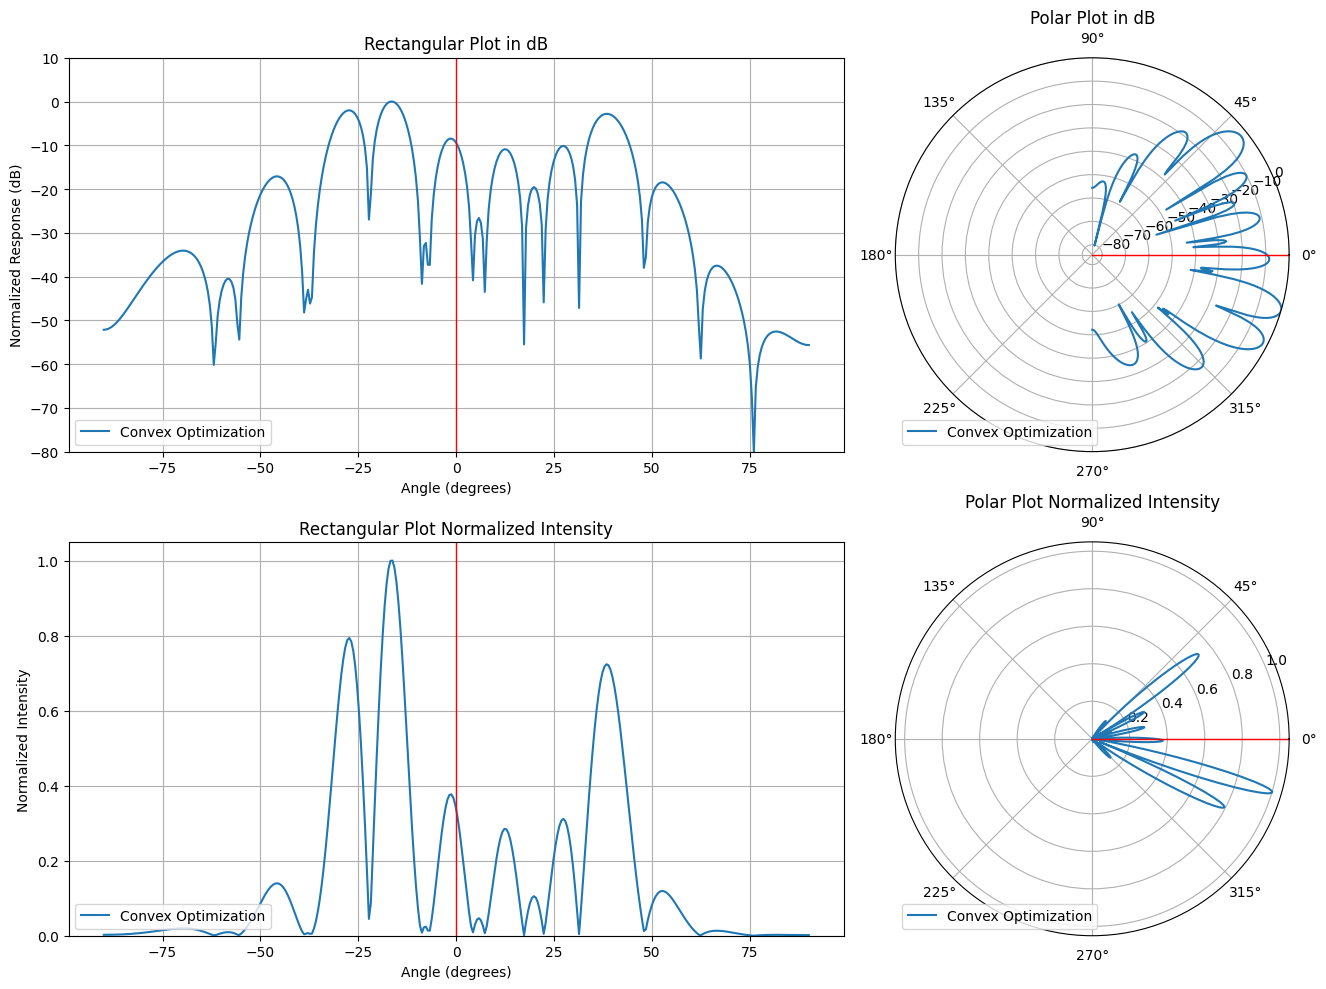

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.animation as animation

# Constants
num_elements = 32  # Number of elements producing sound
total_positions = 34  # Total positions in the array, including empty ones
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Chip specific constants
beamformer_frequency = 250e6  # Beamformer frequency in Hz
discretized_phase_shift = 2 * np.pi / 44  # Discretized phase shift increment
discrete_amplitudes = [0, 0.5, 1]  # Discrete amplitude control

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = 1500  # Speed of sound in water at the given temperature
wavelength = speed_of_sound / frequency  # Wavelength in meters
d = 110e-6  # Element spacing in meters (110 µm)

# Antenna array setup
positions = np.linspace(0, (total_positions - 1) * d, total_positions)
center_position = positions[total_positions // 2]  # Position of the center element
active_indices = [i for i in range(total_positions) if i not in (total_positions // 2 - 1, total_positions // 2)]
element_positions = positions[active_indices] - center_position  # Centering the element positions

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convert delay to phase shift
def delay_to_phase_shift(delay, frequency):
    return 2 * np.pi * frequency * np.array(delay)

# Function to compute steering vector based on delays
def compute_steering_vector(delays, frequency):
    phase_shifts = delay_to_phase_shift(delays, frequency)
    steering_vector = np.exp(1j * phase_shifts)
    return steering_vector

# Example delay array in seconds (replace with your actual delay values)
delayseconds = [
    [2.92e-07, 2.92e-07, 1.8200000000000002e-07, 1.8200000000000002e-07, 7e-08, 7e-08, 2.56e-07, 2.56e-07, 2.3800000000000001e-07, 2.3800000000000001e-07, 1.28e-07, 1.28e-07, 1.8000000000000002e-08, 1.8000000000000002e-08, 2.04e-07, 2.04e-07],
    [4e-09, 4e-09, 1.84e-07, 1.84e-07, 7e-08, 7e-08, 2.5200000000000003e-07, 2.5200000000000003e-07, 2.28e-07, 2.28e-07, 1.14e-07, 1.14e-07, 0.0, 0.0, 1.8200000000000002e-07, 1.8200000000000002e-07],
    [2.8000000000000003e-08, 2.8000000000000003e-08, 2.0600000000000002e-07, 2.0600000000000002e-07, 8.800000000000001e-08, 8.800000000000001e-08, 2.66e-07, 2.66e-07, 2.3600000000000002e-07, 2.3600000000000002e-07, 1.1800000000000001e-07, 1.1800000000000001e-07, 0.0, 0.0, 1.78e-07, 1.78e-07],
    [3.6000000000000005e-08, 3.6000000000000005e-08, 2.1e-07, 2.1e-07, 8.6e-08, 8.6e-08, 2.6e-07, 2.6e-07, 2.26e-07, 2.26e-07, 1.02e-07, 1.02e-07, 2.7600000000000004e-07, 2.7600000000000004e-07, 1.54e-07, 1.54e-07],
    [4.2000000000000006e-08, 4.2000000000000006e-08, 2.1200000000000002e-07, 2.1200000000000002e-07, 8.400000000000001e-08, 8.400000000000001e-08, 2.54e-07, 2.54e-07, 2.14e-07, 2.14e-07, 8.6e-08, 8.6e-08, 2.56e-07, 2.56e-07, 1.3e-07, 1.3e-07],
    [6.000000000000001e-08, 6.000000000000001e-08, 2.26e-07, 2.26e-07, 9.600000000000001e-08, 9.600000000000001e-08, 2.6e-07, 2.6e-07, 2.14e-07, 2.14e-07, 8.2e-08, 8.2e-08, 2.48e-07, 2.48e-07, 1.1800000000000001e-07, 1.1800000000000001e-07],
    [8e-08, 8e-08, 2.42e-07, 2.42e-07, 1.08e-07, 1.08e-07, 2.7e-07, 2.7e-07, 2.16e-07, 2.16e-07, 8e-08, 8e-08, 2.42e-07, 2.42e-07, 1.08e-07, 1.08e-07],
    [1.02e-07, 1.02e-07, 2.6e-07, 2.6e-07, 1.2000000000000002e-07, 1.2000000000000002e-07, 2.7800000000000003e-07, 2.7800000000000003e-07, 2.1800000000000002e-07, 2.1800000000000002e-07, 7.800000000000001e-08, 7.800000000000001e-08, 2.3600000000000002e-07, 2.3600000000000002e-07, 9.8e-08, 9.8e-08],
    [1.24e-07, 1.24e-07, 2.7600000000000004e-07, 2.7600000000000004e-07, 1.34e-07, 1.34e-07, 2.86e-07, 2.86e-07, 2.2e-07, 2.2e-07, 7.6e-08, 7.6e-08, 2.3000000000000002e-07, 2.3000000000000002e-07, 8.6e-08, 8.6e-08],
    [1.4400000000000002e-07, 1.4400000000000002e-07, 2.94e-07, 2.94e-07, 1.46e-07, 1.46e-07, 2.94e-07, 2.94e-07, 2.22e-07, 2.22e-07, 7.4e-08, 7.4e-08, 2.2400000000000002e-07, 2.2400000000000002e-07, 7.6e-08, 7.6e-08],
    [1.58e-07, 1.58e-07, 8e-09, 8e-09, 1.52e-07, 1.52e-07, 0.0, 0.0, 2.16e-07, 2.16e-07, 6.4e-08, 6.4e-08, 2.1e-07, 2.1e-07, 5.8e-08, 5.8e-08],
    [1.72e-07, 1.72e-07, 1.6e-08, 1.6e-08, 1.5600000000000002e-07, 1.5600000000000002e-07, 0.0, 0.0, 2.1e-07, 2.1e-07, 5.4e-08, 5.4e-08, 1.9400000000000002e-07, 1.9400000000000002e-07, 3.8e-08, 3.8e-08],
    [1.8600000000000002e-07, 1.8600000000000002e-07, 2.4000000000000003e-08, 2.4000000000000003e-08, 1.6e-07, 1.6e-07, 0.0, 0.0, 2.04e-07, 2.04e-07, 4.2000000000000006e-08, 4.2000000000000006e-08, 1.78e-07, 1.78e-07, 1.8000000000000002e-08, 1.8000000000000002e-08],
    [2.02e-07, 2.02e-07, 3.6000000000000005e-08, 3.6000000000000005e-08, 1.6800000000000002e-07, 1.6800000000000002e-07, 2e-09, 2e-09, 1.98e-07, 1.98e-07, 3.4e-08, 3.4e-08, 1.64e-07, 1.64e-07, 0.0, 0.0],
    [2.32e-07, 2.32e-07, 6.4e-08, 6.4e-08, 1.9e-07, 1.9e-07, 2e-08, 2e-08, 2.1e-07, 2.1e-07, 4e-08, 4e-08, 1.6800000000000002e-07, 1.6800000000000002e-07, 2.94e-07, 2.94e-07],
    [2.3600000000000002e-07, 2.3600000000000002e-07, 6.000000000000001e-08, 6.000000000000001e-08, 1.8200000000000002e-07, 1.8200000000000002e-07, 8e-09, 8e-09, 1.9200000000000003e-07, 1.9200000000000003e-07, 1.8000000000000002e-08, 1.8000000000000002e-08, 1.4e-07, 1.4e-07, 2.62e-07, 2.62e-07],
    [2.44e-07, 2.44e-07, 6.600000000000001e-08, 6.600000000000001e-08, 1.84e-07, 1.84e-07, 4e-09, 4e-09, 1.8200000000000002e-07, 1.8200000000000002e-07, 2e-09, 2e-09, 1.2000000000000002e-07, 1.2000000000000002e-07, 2.3800000000000001e-07, 2.3800000000000001e-07],
    [2.82e-07, 2.82e-07, 9.8e-08, 9.8e-08, 2.1200000000000002e-07, 2.1200000000000002e-07, 2.8000000000000003e-08, 2.8000000000000003e-08, 1.98e-07, 1.98e-07, 1.4000000000000001e-08, 1.4000000000000001e-08, 1.2600000000000002e-07, 1.2600000000000002e-07, 2.4000000000000003e-07, 2.4000000000000003e-07],
    [0.0, 0.0, 1.08e-07, 1.08e-07, 2.16e-07, 2.16e-07, 2.8000000000000003e-08, 2.8000000000000003e-08, 1.9e-07, 1.9e-07, 2e-09, 2e-09, 1.1e-07, 1.1e-07, 2.2e-07, 2.2e-07],
    [2.4000000000000003e-08, 2.4000000000000003e-08, 1.2600000000000002e-07, 1.2600000000000002e-07, 2.3000000000000002e-07, 2.3000000000000002e-07, 3.8e-08, 3.8e-08, 1.9200000000000003e-07, 1.9200000000000003e-07, 0.0, 0.0, 1.04e-07, 1.04e-07, 2.0600000000000002e-07, 2.0600000000000002e-07],
    [4.8000000000000006e-08, 4.8000000000000006e-08, 1.48e-07, 1.48e-07, 2.46e-07, 2.46e-07, 5.0000000000000004e-08, 5.0000000000000004e-08, 1.98e-07, 1.98e-07, 0.0, 0.0, 9.8e-08, 9.8e-08, 1.98e-07, 1.98e-07],
    [6.2e-08, 6.2e-08, 1.5600000000000002e-07, 1.5600000000000002e-07, 2.5000000000000004e-07, 2.5000000000000004e-07, 4.6e-08, 4.6e-08, 1.8800000000000002e-07, 1.8800000000000002e-07, 2.82e-07, 2.82e-07, 8e-08, 8e-08, 1.7400000000000002e-07, 1.7400000000000002e-07],
    [7.200000000000001e-08, 7.200000000000001e-08, 1.6200000000000002e-07, 1.6200000000000002e-07, 2.5200000000000003e-07, 2.5200000000000003e-07, 4.4000000000000004e-08, 4.4000000000000004e-08, 1.78e-07, 1.78e-07, 2.68e-07, 2.68e-07, 6.000000000000001e-08, 6.000000000000001e-08, 1.5000000000000002e-07, 1.5000000000000002e-07],
    [8.6e-08, 8.6e-08, 1.7000000000000001e-07, 1.7000000000000001e-07, 2.54e-07, 2.54e-07, 4.2000000000000006e-08, 4.2000000000000006e-08, 1.7000000000000001e-07, 1.7000000000000001e-07, 2.54e-07, 2.54e-07, 4.2000000000000006e-08, 4.2000000000000006e-08, 1.2600000000000002e-07, 1.2600000000000002e-07],
    [1.14e-07, 1.14e-07, 1.9400000000000002e-07, 1.9400000000000002e-07, 2.74e-07, 2.74e-07, 5.8e-08, 5.8e-08, 1.7600000000000001e-07, 1.7600000000000001e-07, 2.56e-07, 2.56e-07, 4e-08, 4e-08, 1.2000000000000002e-07, 1.2000000000000002e-07],
    [1.4400000000000002e-07, 1.4400000000000002e-07, 2.1800000000000002e-07, 2.1800000000000002e-07, 2.94e-07, 2.94e-07, 7.200000000000001e-08, 7.200000000000001e-08, 1.84e-07, 1.84e-07, 2.58e-07, 2.58e-07, 3.8e-08, 3.8e-08, 1.1200000000000001e-07, 1.1200000000000001e-07],
    [1.5600000000000002e-07, 1.5600000000000002e-07, 2.26e-07, 2.26e-07, 0.0, 0.0, 7e-08, 7e-08, 1.7400000000000002e-07, 1.7400000000000002e-07, 2.44e-07, 2.44e-07, 1.8000000000000002e-08, 1.8000000000000002e-08, 8.800000000000001e-08, 8.800000000000001e-08],
    [1.7000000000000001e-07, 1.7000000000000001e-07, 2.34e-07, 2.34e-07, 4e-09, 4e-09, 6.8e-08, 6.8e-08, 1.66e-07, 1.66e-07, 2.32e-07, 2.32e-07, 0.0, 0.0, 6.4e-08, 6.4e-08],
    [2.02e-07, 2.02e-07, 2.62e-07, 2.62e-07, 2.6e-08, 2.6e-08, 8.6e-08, 8.6e-08, 1.7600000000000001e-07, 1.7600000000000001e-07, 2.3600000000000002e-07, 2.3600000000000002e-07, 0.0, 0.0, 6.000000000000001e-08, 6.000000000000001e-08],
    [2.14e-07, 2.14e-07, 2.68e-07, 2.68e-07, 2.8000000000000003e-08, 2.8000000000000003e-08, 8.2e-08, 8.2e-08, 1.66e-07, 1.66e-07, 2.2e-07, 2.2e-07, 2.7600000000000004e-07, 2.7600000000000004e-07, 3.4e-08, 3.4e-08],
    [2.42e-07, 2.42e-07, 2.92e-07, 2.92e-07, 4.6e-08, 4.6e-08, 9.600000000000001e-08, 9.600000000000001e-08, 1.7000000000000001e-07, 1.7000000000000001e-07, 2.2e-07, 2.2e-07, 2.7e-07, 2.7e-07, 2.6e-08, 2.6e-08],
    [2.54e-07, 2.54e-07, 2e-09, 2e-09, 4.8000000000000006e-08, 4.8000000000000006e-08, 9.2e-08, 9.2e-08, 1.6e-07, 1.6e-07, 2.0600000000000002e-07, 2.0600000000000002e-07, 2.5000000000000004e-07, 2.5000000000000004e-07, 0.0, 0.0],
    [2.7600000000000004e-07, 2.7600000000000004e-07, 2e-08, 2e-08, 6.000000000000001e-08, 6.000000000000001e-08, 1.0000000000000001e-07, 1.0000000000000001e-07, 1.6e-07, 1.6e-07, 2.0000000000000002e-07, 2.0000000000000002e-07, 2.42e-07, 2.42e-07, 2.82e-07, 2.82e-07],
    [0.0, 0.0, 3.6000000000000005e-08, 3.6000000000000005e-08, 7e-08, 7e-08, 1.0600000000000001e-07, 1.0600000000000001e-07, 1.58e-07, 1.58e-07, 1.9400000000000002e-07, 1.9400000000000002e-07, 2.28e-07, 2.28e-07, 2.6400000000000003e-07, 2.6400000000000003e-07],
    [0.0, 0.0, 3.0000000000000004e-08, 3.0000000000000004e-08, 6.000000000000001e-08, 6.000000000000001e-08, 9.000000000000001e-08, 9.000000000000001e-08, 1.36e-07, 1.36e-07, 1.66e-07, 1.66e-07, 1.96e-07, 1.96e-07, 2.26e-07, 2.26e-07],
    [0.0, 0.0, 2.6e-08, 2.6e-08, 5.0000000000000004e-08, 5.0000000000000004e-08, 7.6e-08, 7.6e-08, 1.14e-07, 1.14e-07, 1.3800000000000002e-07, 1.3800000000000002e-07, 1.64e-07, 1.64e-07, 1.8800000000000002e-07, 1.8800000000000002e-07],
    [0.0, 0.0, 2e-08, 2e-08, 4e-08, 4e-08, 6.000000000000001e-08, 6.000000000000001e-08, 9.000000000000001e-08, 9.000000000000001e-08, 1.1e-07, 1.1e-07, 1.3e-07, 1.3e-07, 1.52e-07, 1.52e-07],
    [0.0, 0.0, 1.6e-08, 1.6e-08, 3.0000000000000004e-08, 3.0000000000000004e-08, 4.6e-08, 4.6e-08, 6.8e-08, 6.8e-08, 8.400000000000001e-08, 8.400000000000001e-08, 9.8e-08, 9.8e-08, 1.14e-07, 1.14e-07],
    [0.0, 0.0, 1e-08, 1e-08, 2e-08, 2e-08, 3.0000000000000004e-08, 3.0000000000000004e-08, 4.6e-08, 4.6e-08, 5.6000000000000005e-08, 5.6000000000000005e-08, 6.600000000000001e-08, 6.600000000000001e-08, 7.6e-08, 7.6e-08],
    [0.0, 0.0, 6.000000000000001e-09, 6.000000000000001e-09, 1e-08, 1e-08, 1.6e-08, 1.6e-08, 2.2000000000000002e-08, 2.2000000000000002e-08, 2.8000000000000003e-08, 2.8000000000000003e-08, 3.2e-08, 3.2e-08, 3.8e-08, 3.8e-08],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [4e-08, 4e-08, 3.6000000000000005e-08, 3.6000000000000005e-08, 3.0000000000000004e-08, 3.0000000000000004e-08, 2.6e-08, 2.6e-08, 1.8000000000000002e-08, 1.8000000000000002e-08, 1.2000000000000002e-08, 1.2000000000000002e-08, 8e-09, 8e-09, 2e-09, 2e-09],
    [8e-08, 8e-08, 7e-08, 7e-08, 6.000000000000001e-08, 6.000000000000001e-08, 5.0000000000000004e-08, 5.0000000000000004e-08, 3.6000000000000005e-08, 3.6000000000000005e-08, 2.6e-08, 2.6e-08, 1.6e-08, 1.6e-08, 6.000000000000001e-09, 6.000000000000001e-09],
    [1.2000000000000002e-07, 1.2000000000000002e-07, 1.0600000000000001e-07, 1.0600000000000001e-07, 9.000000000000001e-08, 9.000000000000001e-08, 7.6e-08, 7.6e-08, 5.2e-08, 5.2e-08, 3.8e-08, 3.8e-08, 2.2000000000000002e-08, 2.2000000000000002e-08, 8e-09, 8e-09],
    [1.6200000000000002e-07, 1.6200000000000002e-07, 1.4e-07, 1.4e-07, 1.2000000000000002e-07, 1.2000000000000002e-07, 1.0000000000000001e-07, 1.0000000000000001e-07, 7e-08, 7e-08, 5.0000000000000004e-08, 5.0000000000000004e-08, 3.0000000000000004e-08, 3.0000000000000004e-08, 1e-08, 1e-08],
    [2.02e-07, 2.02e-07, 1.7600000000000001e-07, 1.7600000000000001e-07, 1.5000000000000002e-07, 1.5000000000000002e-07, 1.2600000000000002e-07, 1.2600000000000002e-07, 8.800000000000001e-08, 8.800000000000001e-08, 6.2e-08, 6.2e-08, 3.8e-08, 3.8e-08, 1.2000000000000002e-08, 1.2000000000000002e-08],
    [2.42e-07, 2.42e-07, 2.1200000000000002e-07, 2.1200000000000002e-07, 1.8200000000000002e-07, 1.8200000000000002e-07, 1.5000000000000002e-07, 1.5000000000000002e-07, 1.0600000000000001e-07, 1.0600000000000001e-07, 7.6e-08, 7.6e-08, 4.6e-08, 4.6e-08, 1.6e-08, 1.6e-08],
    [2.82e-07, 2.82e-07, 2.46e-07, 2.46e-07, 2.1200000000000002e-07, 2.1200000000000002e-07, 1.7600000000000001e-07, 1.7600000000000001e-07, 1.24e-07, 1.24e-07, 8.800000000000001e-08, 8.800000000000001e-08, 5.2e-08, 5.2e-08, 1.8000000000000002e-08, 1.8000000000000002e-08],
    [6.000000000000001e-09, 6.000000000000001e-09, 2.62e-07, 2.62e-07, 2.2e-07, 2.2e-07, 1.8000000000000002e-07, 1.8000000000000002e-07, 1.2000000000000002e-07, 1.2000000000000002e-07, 8e-08, 8e-08, 4e-08, 4e-08, 0.0, 0.0],
    [2.2000000000000002e-08, 2.2000000000000002e-08, 2.74e-07, 2.74e-07, 2.28e-07, 2.28e-07, 1.84e-07, 1.84e-07, 1.16e-07, 1.16e-07, 7e-08, 7e-08, 2.6e-08, 2.6e-08, 2.7600000000000004e-07, 2.7600000000000004e-07],
    [5.0000000000000004e-08, 5.0000000000000004e-08, 0.0, 0.0, 2.46e-07, 2.46e-07, 1.96e-07, 1.96e-07, 1.2000000000000002e-07, 1.2000000000000002e-07, 7e-08, 7e-08, 2e-08, 2e-08, 2.66e-07, 2.66e-07],
    [6.2e-08, 6.2e-08, 6.000000000000001e-09, 6.000000000000001e-09, 2.48e-07, 2.48e-07, 1.9200000000000003e-07, 1.9200000000000003e-07, 1.1e-07, 1.1e-07, 5.6000000000000005e-08, 5.6000000000000005e-08, 0.0, 0.0, 2.4000000000000003e-07, 2.4000000000000003e-07],
    [9.000000000000001e-08, 9.000000000000001e-08, 3.0000000000000004e-08, 3.0000000000000004e-08, 2.66e-07, 2.66e-07, 2.0600000000000002e-07, 2.0600000000000002e-07, 1.16e-07, 1.16e-07, 5.6000000000000005e-08, 5.6000000000000005e-08, 2.92e-07, 2.92e-07, 2.32e-07, 2.32e-07],
    [9.8e-08, 9.8e-08, 3.2e-08, 3.2e-08, 2.6400000000000003e-07, 2.6400000000000003e-07, 1.98e-07, 1.98e-07, 1.02e-07, 1.02e-07, 3.6000000000000005e-08, 3.6000000000000005e-08, 2.68e-07, 2.68e-07, 2.02e-07, 2.02e-07],
    [1.24e-07, 1.24e-07, 5.4e-08, 5.4e-08, 2.8e-07, 2.8e-07, 2.1e-07, 2.1e-07, 1.04e-07, 1.04e-07, 3.4e-08, 3.4e-08, 2.62e-07, 2.62e-07, 1.9200000000000003e-07, 1.9200000000000003e-07],
    [1.5000000000000002e-07, 1.5000000000000002e-07, 7.4e-08, 7.4e-08, 0.0, 0.0, 2.22e-07, 2.22e-07, 1.1e-07, 1.1e-07, 3.4e-08, 3.4e-08, 2.56e-07, 2.56e-07, 1.8200000000000002e-07, 1.8200000000000002e-07],
    [1.6e-07, 1.6e-07, 8e-08, 8e-08, 0.0, 0.0, 2.16e-07, 2.16e-07, 9.8e-08, 9.8e-08, 1.8000000000000002e-08, 1.8000000000000002e-08, 2.34e-07, 2.34e-07, 1.54e-07, 1.54e-07],
    [1.6800000000000002e-07, 1.6800000000000002e-07, 8.400000000000001e-08, 8.400000000000001e-08, 0.0, 0.0, 2.1200000000000002e-07, 2.1200000000000002e-07, 8.6e-08, 8.6e-08, 0.0, 0.0, 2.1200000000000002e-07, 2.1200000000000002e-07, 1.28e-07, 1.28e-07],
    [1.9400000000000002e-07, 1.9400000000000002e-07, 1.0600000000000001e-07, 1.0600000000000001e-07, 1.6e-08, 1.6e-08, 2.2400000000000002e-07, 2.2400000000000002e-07, 9.000000000000001e-08, 9.000000000000001e-08, 0.0, 0.0, 2.0600000000000002e-07, 2.0600000000000002e-07, 1.1800000000000001e-07, 1.1800000000000001e-07],
    [2.2e-07, 2.2e-07, 1.2600000000000002e-07, 1.2600000000000002e-07, 3.2e-08, 3.2e-08, 2.34e-07, 2.34e-07, 9.400000000000001e-08, 9.400000000000001e-08, 0.0, 0.0, 2.02e-07, 2.02e-07, 1.08e-07, 1.08e-07],
    [2.46e-07, 2.46e-07, 1.48e-07, 1.48e-07, 5.0000000000000004e-08, 5.0000000000000004e-08, 2.46e-07, 2.46e-07, 9.8e-08, 9.8e-08, 2.96e-07, 2.96e-07, 1.98e-07, 1.98e-07, 9.8e-08, 9.8e-08],
    [2.58e-07, 2.58e-07, 1.5600000000000002e-07, 1.5600000000000002e-07, 5.2e-08, 5.2e-08, 2.44e-07, 2.44e-07, 9.000000000000001e-08, 9.000000000000001e-08, 2.82e-07, 2.82e-07, 1.78e-07, 1.78e-07, 7.4e-08, 7.4e-08],
    [2.74e-07, 2.74e-07, 1.64e-07, 1.64e-07, 5.6000000000000005e-08, 5.6000000000000005e-08, 2.44e-07, 2.44e-07, 8.2e-08, 8.2e-08, 2.7e-07, 2.7e-07, 1.6200000000000002e-07, 1.6200000000000002e-07, 5.4e-08, 5.4e-08],
    [0.0, 0.0, 1.84e-07, 1.84e-07, 7e-08, 7e-08, 2.54e-07, 2.54e-07, 8.400000000000001e-08, 8.400000000000001e-08, 2.68e-07, 2.68e-07, 1.54e-07, 1.54e-07, 4.2000000000000006e-08, 4.2000000000000006e-08],
    [0.0, 0.0, 1.78e-07, 1.78e-07, 6.2e-08, 6.2e-08, 2.4000000000000003e-07, 2.4000000000000003e-07, 6.4e-08, 6.4e-08, 2.42e-07, 2.42e-07, 1.24e-07, 1.24e-07, 8e-09, 8e-09],
    [2.6e-08, 2.6e-08, 2.0000000000000002e-07, 2.0000000000000002e-07, 7.800000000000001e-08, 7.800000000000001e-08, 2.5200000000000003e-07, 2.5200000000000003e-07, 7e-08, 7e-08, 2.44e-07, 2.44e-07, 1.22e-07, 1.22e-07, 0.0, 0.0],
    [6.2e-08, 6.2e-08, 2.3000000000000002e-07, 2.3000000000000002e-07, 1.04e-07, 1.04e-07, 2.74e-07, 2.74e-07, 8.400000000000001e-08, 8.400000000000001e-08, 2.54e-07, 2.54e-07, 1.2600000000000002e-07, 1.2600000000000002e-07, 0.0, 0.0],
    [6.600000000000001e-08, 6.600000000000001e-08, 2.3000000000000002e-07, 2.3000000000000002e-07, 1.0000000000000001e-07, 1.0000000000000001e-07, 2.6400000000000003e-07, 2.6400000000000003e-07, 6.8e-08, 6.8e-08, 2.32e-07, 2.32e-07, 1.02e-07, 1.02e-07, 2.66e-07, 2.66e-07],
    [8.6e-08, 8.6e-08, 2.46e-07, 2.46e-07, 1.1e-07, 1.1e-07, 2.72e-07, 2.72e-07, 6.8e-08, 6.8e-08, 2.28e-07, 2.28e-07, 9.2e-08, 9.2e-08, 2.54e-07, 2.54e-07],
    [1.08e-07, 1.08e-07, 2.6400000000000003e-07, 2.6400000000000003e-07, 1.24e-07, 1.24e-07, 2.8e-07, 2.8e-07, 7e-08, 7e-08, 2.26e-07, 2.26e-07, 8.6e-08, 8.6e-08, 2.42e-07, 2.42e-07],
    [1.3e-07, 1.3e-07, 2.82e-07, 2.82e-07, 1.3800000000000002e-07, 1.3800000000000002e-07, 2.8800000000000004e-07, 2.8800000000000004e-07, 7.200000000000001e-08, 7.200000000000001e-08, 2.2400000000000002e-07, 2.2400000000000002e-07, 8e-08, 8e-08, 2.32e-07, 2.32e-07],
    [1.5000000000000002e-07, 1.5000000000000002e-07, 2e-09, 2e-09, 1.48e-07, 1.48e-07, 0.0, 0.0, 7.200000000000001e-08, 7.200000000000001e-08, 2.2e-07, 2.2e-07, 7.200000000000001e-08, 7.200000000000001e-08, 2.1800000000000002e-07, 2.1800000000000002e-07],
    [1.6200000000000002e-07, 1.6200000000000002e-07, 1e-08, 1e-08, 1.52e-07, 1.52e-07, 0.0, 0.0, 6.600000000000001e-08, 6.600000000000001e-08, 2.1e-07, 2.1e-07, 5.6000000000000005e-08, 5.6000000000000005e-08, 2.0000000000000002e-07, 2.0000000000000002e-07],
    [1.7600000000000001e-07, 1.7600000000000001e-07, 1.8000000000000002e-08, 1.8000000000000002e-08, 1.58e-07, 1.58e-07, 0.0, 0.0, 6.000000000000001e-08, 6.000000000000001e-08, 1.98e-07, 1.98e-07, 4.2000000000000006e-08, 4.2000000000000006e-08, 1.8000000000000002e-07, 1.8000000000000002e-07],
    [1.8800000000000002e-07, 1.8800000000000002e-07, 2.6e-08, 2.6e-08, 1.6200000000000002e-07, 1.6200000000000002e-07, 0.0, 0.0, 5.4e-08, 5.4e-08, 1.8800000000000002e-07, 1.8800000000000002e-07, 2.8000000000000003e-08, 2.8000000000000003e-08, 1.6200000000000002e-07, 1.6200000000000002e-07],
    [2.0000000000000002e-07, 2.0000000000000002e-07, 3.6000000000000005e-08, 3.6000000000000005e-08, 1.66e-07, 1.66e-07, 0.0, 0.0, 4.8000000000000006e-08, 4.8000000000000006e-08, 1.78e-07, 1.78e-07, 1.2000000000000002e-08, 1.2000000000000002e-08, 1.42e-07, 1.42e-07],
    [2.14e-07, 2.14e-07, 4.6e-08, 4.6e-08, 1.72e-07, 1.72e-07, 2e-09, 2e-09, 4.4000000000000004e-08, 4.4000000000000004e-08, 1.7000000000000001e-07, 1.7000000000000001e-07, 0.0, 0.0, 1.2600000000000002e-07, 1.2600000000000002e-07],
    [2.42e-07, 2.42e-07, 6.8e-08, 6.8e-08, 1.9e-07, 1.9e-07, 1.6e-08, 1.6e-08, 5.2e-08, 5.2e-08, 1.7400000000000002e-07, 1.7400000000000002e-07, 0.0, 0.0, 1.22e-07, 1.22e-07],
    [2.66e-07, 2.66e-07, 8.800000000000001e-08, 8.800000000000001e-08, 2.08e-07, 2.08e-07, 3.0000000000000004e-08, 3.0000000000000004e-08, 5.8e-08, 5.8e-08, 1.78e-07, 1.78e-07, 2.96e-07, 2.96e-07, 1.1800000000000001e-07, 1.1800000000000001e-07],
    [2.72e-07, 2.72e-07, 9.000000000000001e-08, 9.000000000000001e-08, 2.0600000000000002e-07, 2.0600000000000002e-07, 2.4000000000000003e-08, 2.4000000000000003e-08, 4.8000000000000006e-08, 4.8000000000000006e-08, 1.6200000000000002e-07, 1.6200000000000002e-07, 2.7600000000000004e-07, 2.7600000000000004e-07, 9.400000000000001e-08, 9.400000000000001e-08],
    [0.0, 0.0, 1.1e-07, 1.1e-07, 2.2e-07, 2.2e-07, 3.6000000000000005e-08, 3.6000000000000005e-08, 5.4e-08, 5.4e-08, 1.64e-07, 1.64e-07, 2.74e-07, 2.74e-07, 8.800000000000001e-08, 8.800000000000001e-08],
]

# Expand the delay array to match 32 elements (duplicating each value)
expanded_delayseconds = [np.repeat(delays, 2) for delays in delayseconds]

# Function to plot beam pattern
def plot_beam_patterns(axs_db, axs_norm, ax_polar_db, ax_polar_norm, weights_list, labels, element_positions, wavelength, theta_s, theta_i, angles):
    for weights, label in zip(weights_list, labels):
        beam_pattern = np.abs([steering_vector(deg, element_positions, wavelength).conj().T @ weights for deg in angles]).flatten()
        beam_pattern_db = 20 * np.log10(beam_pattern / np.max(beam_pattern))
        beam_pattern_norm = beam_pattern / np.max(beam_pattern)

        axs_db.plot(angles, beam_pattern_db, label=label)
        axs_norm.plot(angles, beam_pattern_norm, label=label)
        ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db, label=label)
        ax_polar_norm.plot(np.deg2rad(angles), beam_pattern_norm, label=label)

    for ax in [axs_db, axs_norm]:
        ax.axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')

    axs_db.set_title('Rectangular Plot in dB')
    axs_db.set_xlabel('Angle (degrees)')
    axs_db.set_ylabel('Normalized Response (dB)')
    axs_db.set_ylim(-80, 10)  # Set y-axis limits to remain constant
    axs_db.grid(True)
    axs_db.legend(loc='lower left')  # Set legend position to bottom left

    axs_norm.set_title('Rectangular Plot Normalized Intensity')
    axs_norm.set_xlabel('Angle (degrees)')
    axs_norm.set_ylabel('Normalized Intensity')
    axs_norm.set_ylim(0, 1.05)  # Set y-axis limits to remain constant
    axs_norm.grid(True)
    axs_norm.legend(loc='lower left')  # Set legend position to bottom left

    ax_polar_db.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_db.set_title('Polar Plot in dB')
    ax_polar_db.legend(loc='lower left')

    ax_polar_norm.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_norm.set_title('Polar Plot Normalized Intensity')
    ax_polar_norm.legend(loc='lower left')

# Generate video frames
def generate_frames():
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    ax_db, ax_norm = axs[0, 0], axs[1, 0]
    ax_polar_db = plt.subplot(2, 2, 2, polar=True)
    ax_polar_norm = plt.subplot(2, 2, 4, polar=True)
    angles = np.linspace(-90, 90, 360)
    theta_s = 0  # Angle of the desired signal (in degrees)
    theta_i = 30  # Angle of the interfering signal (in degrees)

    def update(frame):
        ax_db.clear()
        ax_norm.clear()
        ax_polar_db.clear()
        ax_polar_norm.clear()
        delays = expanded_delayseconds[frame % len(expanded_delayseconds)]
        steering_vector = compute_steering_vector(delays, frequency)
        weights_list = [steering_vector]
        plot_beam_patterns(ax_db, ax_norm, ax_polar_db, ax_polar_norm, weights_list, ["Convex Optimization"], element_positions, wavelength, theta_s, theta_i, angles)
        plt.tight_layout()

    return fig, update

# Create video
fig, update = generate_frames()
ani = animation.FuncAnimation(fig, update, frames=len(expanded_delayseconds), repeat=False)

# Save video
ani.save('beamforming_video.mp4', writer='ffmpeg', fps=20)

plt.show()


<ipython-input-1-6f0080278356>:71: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_polar_db = plt.subplot(2, 2, 2, polar=True)
<ipython-input-1-6f0080278356>:72: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_polar_norm = plt.subplot(2, 2, 4, polar=True)


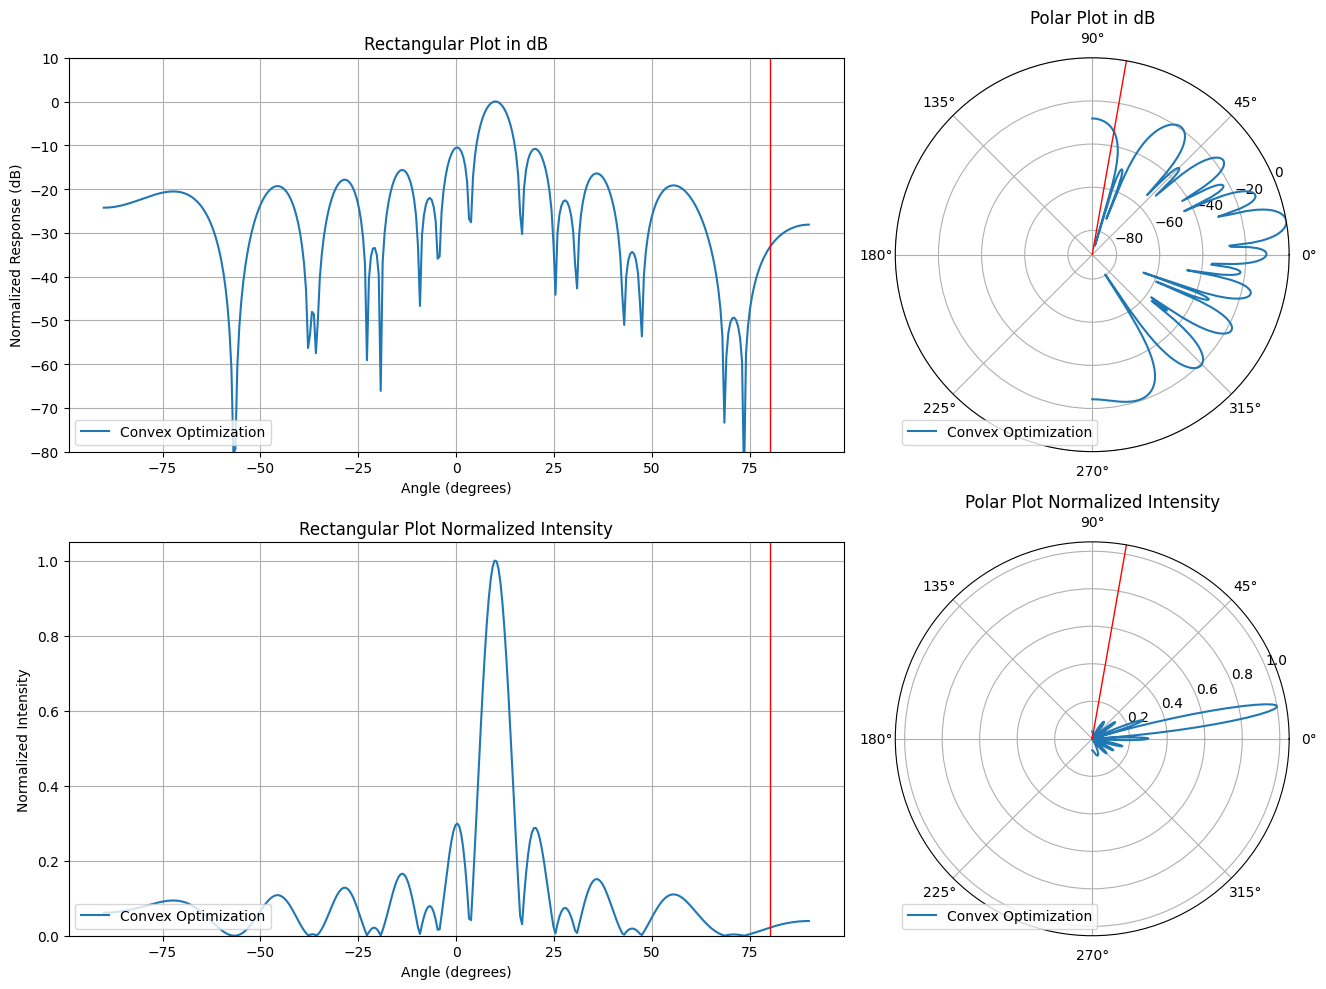

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.animation as animation

# Constants
num_elements = 32  # Number of elements producing sound
total_positions = 34  # Total positions in the array, including empty ones
temperature = 21  # in Celsius
frequency = 1/(37*2*4*10**-9)  # Frequency in Hz

# Chip specific constants
beamformer_frequency = 250e6  # Beamformer frequency in Hz
discretized_phase_shift = 2 * np.pi / 44  # Discretized phase shift increment
discrete_amplitudes = [0, 0.5, 1]  # Discrete amplitude control

# Function to calculate the speed of sound in water based on temperature
def speed_of_sound_in_water(T):
    return 1449.2 + 4.6 * T - 0.055 * T**2 + 0.00029 * T**3

speed_of_sound = 1500  # Speed of sound in water at the given temperature
wavelength = speed_of_sound / frequency  # Wavelength in meters
d = 110e-6  # Element spacing in meters (110 µm)

# Convert element positions to a NumPy array
element_positions = np.array([-0.001815, -0.001705, -0.001595, -0.001485, -0.001375, -0.001265, -0.001155, -0.001045,
                     -0.000935, -0.000825, -0.000715, -0.000605, -0.000495, -0.000385, -0.000275, -0.000165,
                     0.000165, 0.000275, 0.000385, 0.000495, 0.000605, 0.000715, 0.000825, 0.000935, 0.001045,
                     0.001155, 0.001265, 0.001375, 0.001485, 0.001595, 0.001705, 0.001815])

# Desired signal direction in degrees
theta_s = 10  # Desired signal direction
theta_i = []  # No interference directions in this example

# Calculate steering vector
def steering_vector(theta, array_positions, wavelength):
    k = 2 * np.pi / wavelength
    angles_rad = np.deg2rad(theta)
    steering = np.exp(-1j * k * array_positions * np.sin(angles_rad))
    return steering

# Convex Optimization-based Beamforming function with paired phase constraints
def convex_optimization_beamforming(theta_s, element_positions, wavelength, interference_directions, noise_power=0.1, interference_power=[1]):
    num_pairs = len(element_positions) // 2  # Number of pairs
    v_s = steering_vector(theta_s, element_positions, wavelength)
    v_i = [steering_vector(theta, element_positions, wavelength) for theta in interference_directions]

    # Define the optimization variables and constraints
    w_pair = cp.Variable(num_pairs, complex=True)  # Shared weights for each pair
    w = cp.hstack([w_pair[i//2] for i in range(len(element_positions))])  # Repeat weights for each pair of nodes

    constraints = [cp.norm(w) <= 1]  # Constraint to ensure weights are normalized
    interference_constraints = [cp.abs(w.H @ v_i[k]) <= np.sqrt(interference_power[k]) for k in range(len(v_i))]

    # Define the problem
    objective = cp.Minimize(cp.quad_form(w, np.eye(len(element_positions)) * noise_power) - cp.real(w.H @ v_s))
    prob = cp.Problem(objective, constraints + interference_constraints)

    # Solve the problem
    prob.solve()
    w_opt = w.value
    return w_opt

# Beamforming weights
w_opt = convex_optimization_beamforming(theta_s, element_positions, wavelength, theta_i)

# Generate video frames
def generate_frames():
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    ax_db, ax_norm = axs[0, 0], axs[1, 0]
    ax_polar_db = plt.subplot(2, 2, 2, polar=True)
    ax_polar_norm = plt.subplot(2, 2, 4, polar=True)
    angles = np.linspace(-90, 90, 360)

    def update(theta_s):
        ax_db.clear()
        ax_norm.clear()
        ax_polar_db.clear()
        ax_polar_norm.clear()
        weights_list = [w_opt]
        plot_beam_patterns(ax_db, ax_norm, ax_polar_db, ax_polar_norm, weights_list, ["Convex Optimization"], element_positions, wavelength, theta_s, theta_i, angles)
        plt.tight_layout()

    return fig, update

# Function to plot beam pattern
def plot_beam_patterns(axs_db, axs_norm, ax_polar_db, ax_polar_norm, weights_list, labels, element_positions, wavelength, theta_s, theta_i, angles):
    for weights, label in zip(weights_list, labels):
        beam_pattern = np.abs([steering_vector(deg, element_positions, wavelength).conj().T @ weights for deg in angles]).flatten()
        beam_pattern_db = 20 * np.log10(beam_pattern / np.max(beam_pattern))
        beam_pattern_norm = beam_pattern / np.max(beam_pattern)

        axs_db.plot(angles, beam_pattern_db, label=label)
        axs_norm.plot(angles, beam_pattern_norm, label=label)
        ax_polar_db.plot(np.deg2rad(angles), beam_pattern_db, label=label)
        ax_polar_norm.plot(np.deg2rad(angles), beam_pattern_norm, label=label)

    for ax in [axs_db, axs_norm]:
        ax.axvline(theta_s, color='red', linestyle='-', linewidth=1, label='_nolegend_')

    axs_db.set_title('Rectangular Plot in dB')
    axs_db.set_xlabel('Angle (degrees)')
    axs_db.set_ylabel('Normalized Response (dB)')
    axs_db.set_ylim(-80, 10)  # Set y-axis limits to remain constant
    axs_db.grid(True)
    axs_db.legend(loc='lower left')  # Set legend position to bottom left

    axs_norm.set_title('Rectangular Plot Normalized Intensity')
    axs_norm.set_xlabel('Angle (degrees)')
    axs_norm.set_ylabel('Normalized Intensity')
    axs_norm.set_ylim(0, 1.05)  # Set y-axis limits to remain constant
    axs_norm.grid(True)
    axs_norm.legend(loc='lower left')  # Set legend position to bottom left

    ax_polar_db.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_db.set_title('Polar Plot in dB')
    ax_polar_db.legend(loc='lower left')

    ax_polar_norm.axvline(np.deg2rad(theta_s), color='red', linestyle='-', linewidth=1, label='_nolegend_')
    ax_polar_norm.set_title('Polar Plot Normalized Intensity')
    ax_polar_norm.legend(loc='lower left')

# Create video
fig, update = generate_frames()
ani = animation.FuncAnimation(fig, update, frames=np.arange(-90, 90, 10), repeat=False)

# Save video
ani.save('beamforming_video.mp4', writer='ffmpeg', fps=20)

plt.show()
